Tag-and-Probe is a data-driven technique used to calculate lepton reconstruction, identification, and trigger efficiencies. This technique uses narrow dilepton resonances, such as Z (for muons with relatively high pT) or J/ψ (for muons with lower pT). Almost-unbiased estimates of the efficiencies can be obtained at the different stages of muon trigger and offline reconstruction. Events are selected with strict requirements on one muon (the tag), and with a more relaxed selection on the other muon (the probe), such that the probe muon can be used to measure the efficiency in question without large biases. The fraction of probe muons that pass the selection under study gives an estimate of its efficiency. The invariant mass of the tag-probe pair is used to select Z→μμ or J/ψ→μμ events.
The Tag-and-Probe technique is generally used to measure and compare efficiencies in data and in MC simulation, and thus to compute a correction scale factor that can be applied to MC events to match the efficiency observed in data. These scale factors are typically determined as functions of pT and η. If necessary, their dependence on other kinematic variables can be investigated too — e.g. vs the number of vertices, in case of strong pileup dependence. In some cases, customized scale factors are necessary for some analyses, depending on their specific trigger and offline thresholds.

Despite the tight selection on the tag muon and the invariant mass constraints, the selected Z→μμ or J/ψ→μμ sample generally contains background events, which appear as a nonresonant continuum underneath the resonance peak. Therefore the background must be subtracted, to ensure that the efficiency is measured with signal muons only. This can be achieved by fitting the invariant mass spectrum to signal + background shapes (e.g. analytical functions or MC templates). Finding proper functions or templates for signal and background is often the most challenging part of the process.

The total lepton efficiency is generally factorized in multiple steps as follows:
total lepton efficiency = (tracking) × (reconstruction/tracking) × (ID/reconstruction) × (isolation/ID) × (trigger/isolation)
In each efficiency step, the denominator determines the selection of the probe. In the last steps (in part. isolation and trigger), the probe selection is tighter and, therefore, the background level is quite low and the background subtraction is generally easier — or not even needed, in some cases. In this exercise, you will measure efficiencies using simulated Z→μμ events:
/home/common/LongExercises/Muon/Samples/DYJetsMuMu_MadGraph_NLO.root
/home/common/LongExercises/Muon/Samples/DYJetsMuMu_MadGraph_NLO_1.root
Since you are using a pure Z sample, you won't need background subtraction nor fitting. The efficiency will simply be computed by counting probes before and after the selection under study.

You will start by computing "true" efficiencies using the generator-level information. This will be your reference efficiencies. Next, you will implement a simple tag-and-probe algorithm to measure the efficiencies with a data-driven approach, and you will compare your results to the "true" efficiencies. Finally, you will try to use the same algorithm on a real single-muon data sample:
/.../datasample.root

In [312]:
import uproot
import ROOT
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import uproot_methods
from math import pi, sqrt, cosh, cos
dR=0.1

In [3]:
file=uproot.open('~/Downloads/DYJetsToMuMu_M-50_TuneCP5_14TeV-madgraphMLM-pythia8.root')['Events']

In [17]:
TrigObj_id=file.array('TrigObj_id')
HLT_IsoMu24= file.array('HLT_IsoMu24')

In [18]:
HLT_IsoMu24.shape

(140277,)

In [27]:
(HLT_IsoMu24==1).sum()

84760

In [19]:
trigmu=(abs(TrigObj_id)==13)

In [20]:
trigmu.sum()

array([1, 0, 2, ..., 2, 2, 2])

In [26]:
((trigmu.sum()[HLT_IsoMu24==1])==0).sum()

0

In [68]:
trigpt=file.array('TrigObj_pt')

In [69]:
(trigpt[abs(TrigObj_id)==13][HLT_IsoMu24==1])>24

<JaggedArray [[True] [True True] [True] ... [True True] [True True] [True True]] at 0x7f94eb2e1c90>

In [193]:
genpart_mask=(file.array('GenPart_pt')>20)& (abs(file.array('GenPart_eta'))<2.4)& (abs(file.array('GenPart_pdgId'))==13)& (file.array('GenPart_status')==1)& ((file.array('GenPart_statusFlags')%2)==1)

In [210]:
gen_muon=ak.JaggedArray.zip(pt= file.array('GenPart_pt')[genpart_mask], 
                            eta= file.array('GenPart_eta')[genpart_mask], 
                            phi= file.array('GenPart_phi')[genpart_mask],
                            npv= file.array('PV_npvsGood'))
                             
                             

In [292]:
muon=ak.JaggedArray.zip(muon_pt=file.array('Muon_pt'), muon_eta= file.array('Muon_eta'), muon_phi= file.array('Muon_phi'),
                        muon_isglobal= file.array('Muon_isGlobal'), muon_istracker= file.array('Muon_isTracker'),
                        muon_mass= file.array('Muon_mass'),
                        muon_charge= file.array('Muon_charge'),
                        muon_dxy=file.array('Muon_dxy'),
                        muon_dz=file.array('Muon_dz'),
                        muon_pfreliso04_all= file.array('Muon_pfRelIso04_all'), 
                        muon_tkreliso= file.array('Muon_tkRelIso'),
                        muon_looseid= file.array('Muon_looseId'), 
                        muon_mediumid= file.array('Muon_mediumId'), 
                        muon_tightid= file.array('Muon_tightId'), 
                        muon_genpartidx= file.array('Muon_genPartIdx'),
                        pv_npvsgood= file.array('PV_npvsGood'),
                        genpart_pt= file.array('GenPart_pt')[file.array('Muon_genPartIdx')],
                        genpart_eta= file.array('GenPart_eta')[file.array('Muon_genPartIdx')],
                        genpart_phi= file.array('GenPart_phi')[file.array('Muon_genPartIdx')],
                        genpart_pdgid= file.array('GenPart_pdgId')[file.array('Muon_genPartIdx')],
                        genpart_status= file.array('GenPart_status')[file.array('Muon_genPartIdx')],
                        genpart_statusFlags= file.array('GenPart_statusFlags')[file.array('Muon_genPartIdx')],
                        )


In [74]:
trigger_muon=ak.JaggedArray.zip(pt=file.array('TrigObj_pt')[abs(file.array('TrigObj_id'))==13],
                                eta= file.array('TrigObj_eta')[abs(file.array('TrigObj_id'))==13], 
                                phi= file.array('TrigObj_phi')[abs(file.array('TrigObj_id'))==13])

In [86]:
def deltaR(genetas, eta, genphis, phi):
    return np.sqrt((genetas-eta)**2+((genphis-phi+pi)%(2*pi)-pi)**2)

In [164]:
def deltar_matching(genpart_eta, genpart_phi, reco_eta, reco_phi):
    list=[]
    for genetas, genphis, etas, phis in zip(genpart_eta, genpart_phi, reco_eta, reco_phi):
        i=[]
        if len(etas)==0:
            list.append([])
            continue
        
        for eta, phi in zip(etas, phis):
            if len(genetas)==0:
                i.append(False)
            else:
                deltar=deltaR(genetas, eta, genphis, phi)
                if (deltar.min()<dR):
                     i.append(True)
                else:
                     i.append(False)    
        
        list.append(i)
    return ak.fromiter(list)
    

In [245]:
c={}
def TH1_fill_and_plot(th1, array, name):
    
    for a in array.flatten():
        th1.Fill(a)
        
    c[f'{name}']= ROOT.TCanvas(f'{name}',"",900,600)
    th1.Draw()
    c[f'{name}'].Draw()

In [280]:
c1={}
def eff_fill_and_plot(th1, name):
     
    c1[f'{name}']= ROOT.TCanvas(f'{name}',"",900,600)
    th1.Draw()
    c1[f'{name}'].Draw()

Now lets set a few cut on the event

* Event cut: must has at least a good vertex
* Particle cut: 1. correspond genpart must be good muon 2. fired a trigger

In [188]:
good_gen_mask=(muon.genpart_pt>20)& (abs(muon.genpart_eta)<2.4)& (abs(muon.genpart_pdgid)==13)& (muon.genpart_status==1)& ((muon.genpart_statusFlags%2)==1)

In [261]:
event_mask_goodpv= file.array('PV_npvsGood')>0

In [262]:
event_mask_goodpv_HLT_isomu24= (file.array('PV_npvsGood')>0)& (file.array('HLT_IsoMu24')==1)

In [263]:
trigger_match_mask=deltar_matching(trigger_muon.eta, trigger_muon.phi, muon.muon_eta, muon.muon_phi)

In [264]:
muon_mask={}
muon_mask['rec']= good_gen_mask
muon_mask['rec_loose']= good_gen_mask& (muon.muon_looseid==1) 
muon_mask['rec_medium']= good_gen_mask& (muon.muon_mediumid==1) 
muon_mask['rec_tight']= good_gen_mask& (muon.muon_tightid==1)
muon_mask['rec_tight_iso']= good_gen_mask& (muon.muon_tightid==1)& (muon.muon_pfreliso04_all< 0.12)
muon_mask['rec_tight_iso_hlt']= good_gen_mask& (muon.muon_tightid==1)& (muon.muon_pfreliso04_all< 0.12)& trigger_match_mask

In [172]:
h_pt   =ROOT.TH1D("pt"  , ";GEN muon p_{T} [GeV];Events",  20,  20.0, 120.0) 
h_eta  =ROOT.TH1D("eta" , ";GEN muon #eta;Events"       ,  24,  -2.4,   2.4)
h_nvtx =ROOT.TH1D("nvtx", ";N. vertices;Events"         ,  60,   0.5,  60.5)

h_rec_pt   = ROOT.TH1D("rec_pt"  , "PAT muon p_{T} [GeV]Events",  20,  20.0, 120.0) 
h_rec_eta  = ROOT.TH1D("rec_eta" , "PAT muon #etaEvents"       ,  24,  -2.4,   2.4) 
h_rec_nvtx = ROOT.TH1D("rec_nvtx", "N. verticesEvents"         ,  60,   0.5,  60.5) 

nbinpt   = h_rec_pt.GetNbinsX() 
nbineta  = h_rec_eta.GetNbinsX() 
nbinnvtx = h_rec_nvtx.GetNbinsX()
90


gae_rec_pt   = ROOT.TGraphAsymmErrors(nbinpt  ) 
gae_rec_pt.SetName("eff_rec_pt")
gae_rec_eta  = ROOT.TGraphAsymmErrors(nbineta ) 
gae_rec_eta.SetName("eff_rec_eta")
gae_rec_nvtx = ROOT.TGraphAsymmErrors(nbinnvtx)
gae_rec_nvtx.SetName("eff_rec_nvtx")

Warning in <TROOT::Append>: Replacing existing TH1: pt (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: eta (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: nvtx (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: rec_pt (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: rec_eta (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: rec_nvtx (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_gen_pt
Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_gen_eta
Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_gen_nvtx
Warning in <TROOT::Append>: Replacing existing TH1: pt (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_rec_pt
Warning in <TROOT::Append>: Replacing existing TH1: eta (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_rec_eta
Warning in <TROOT::Append>: Replacing existing TH1: nvtx (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_rec_nvtx
Info in <TROOT::TEfficiency::CheckEntries>: Histograms are not consistent: passed bin content > total bin content
Error in <TROOT::TEfficiency::CheckConsistency>: passed TEfficiency objects do not have consistent bin contents
Error in <TGraphAsymmErrors::Divide>: passed histograms are not consi

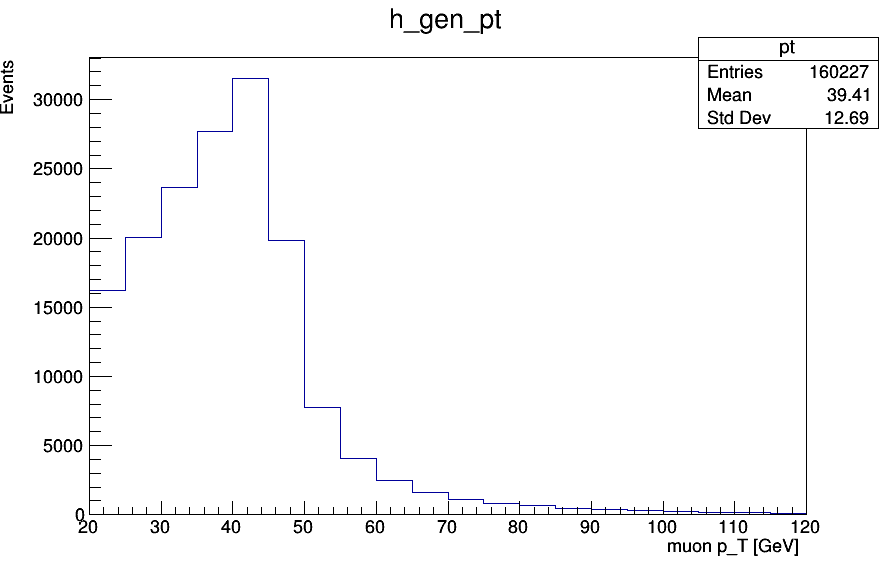

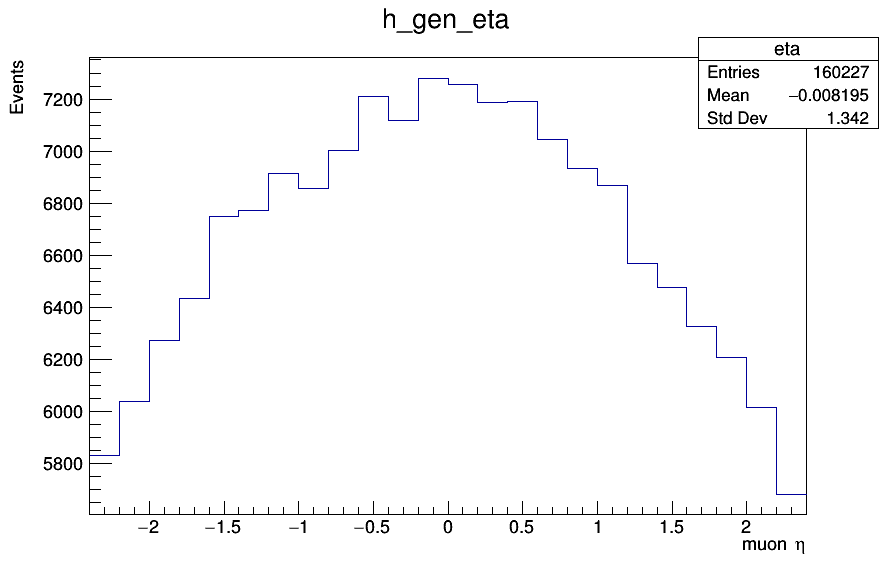

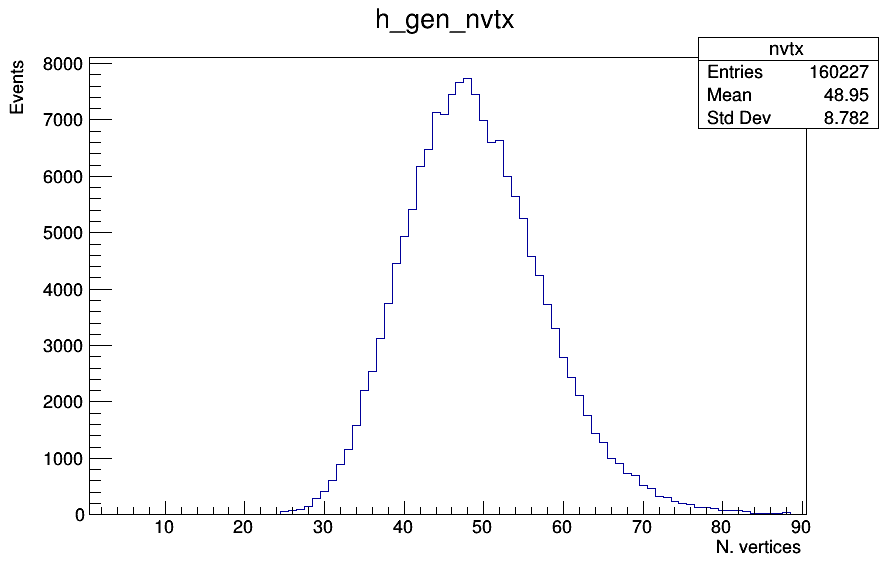

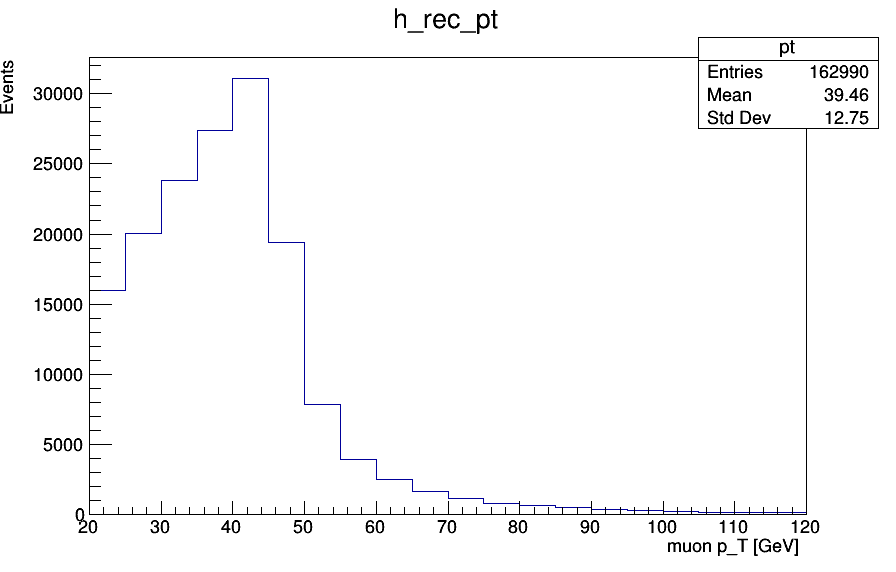

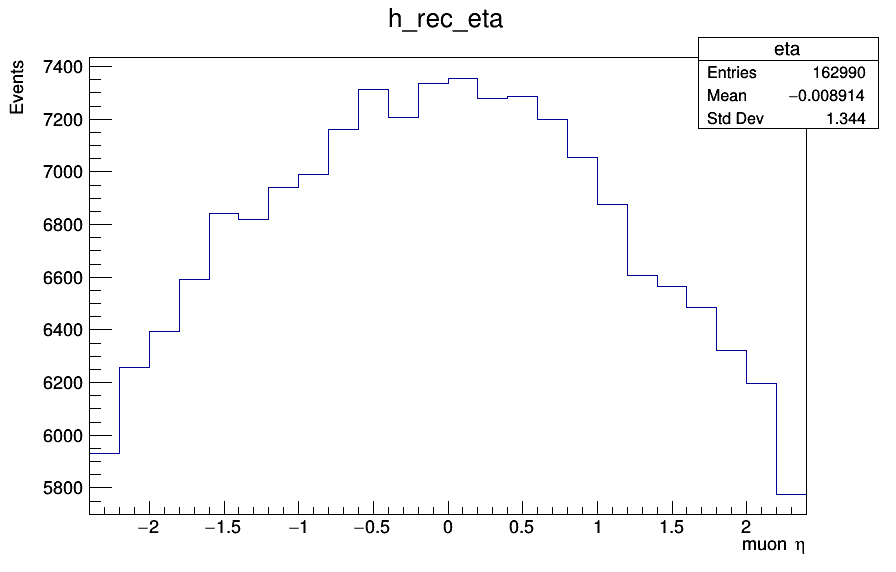

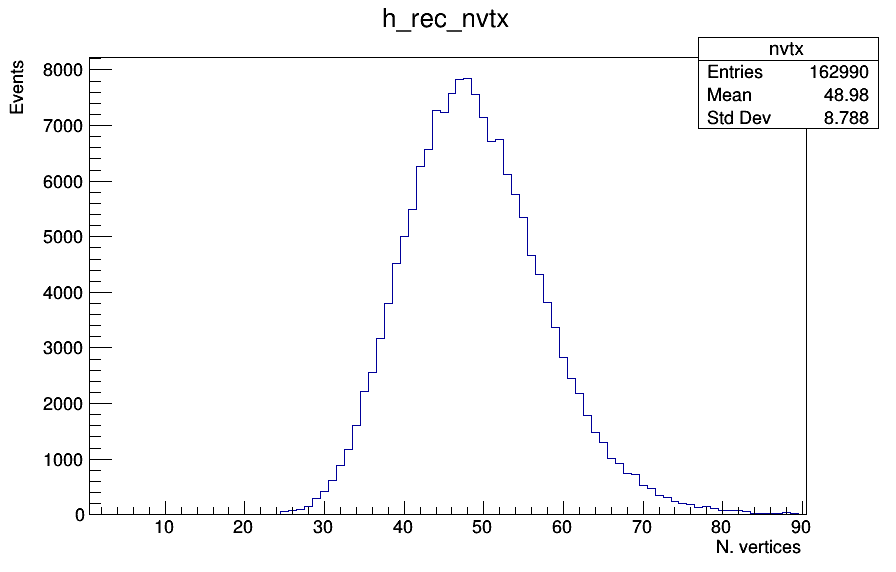

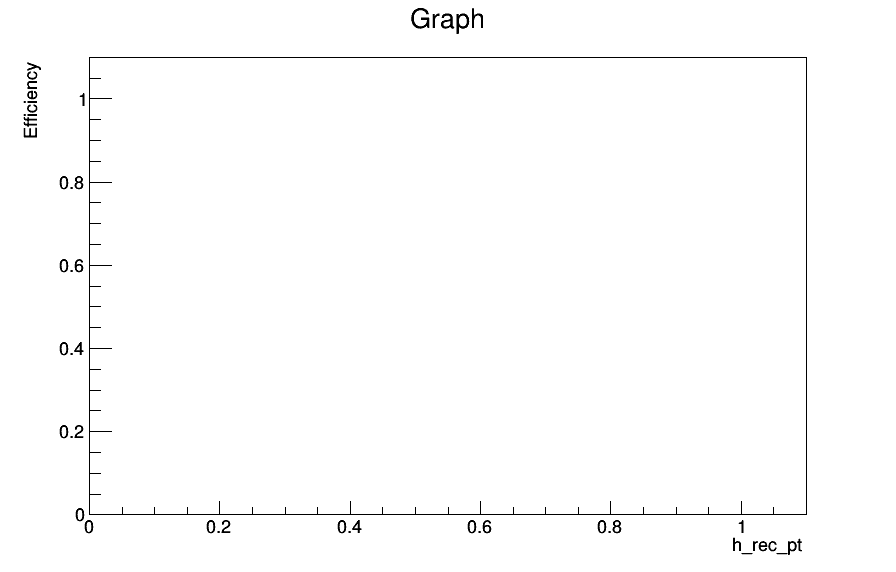

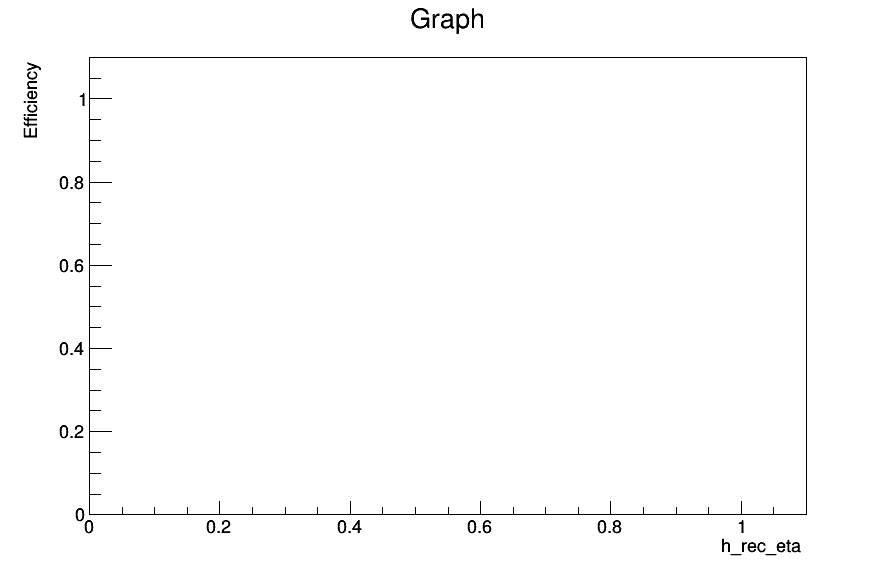

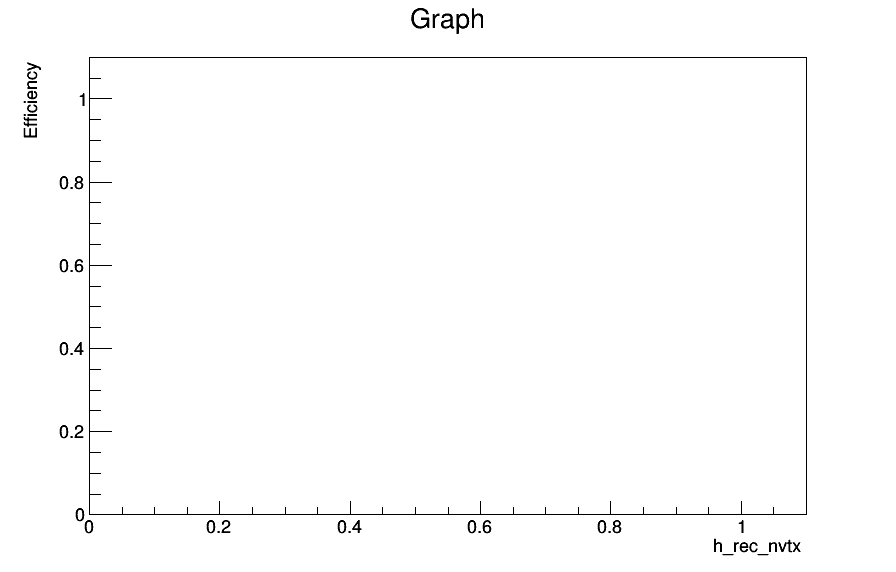

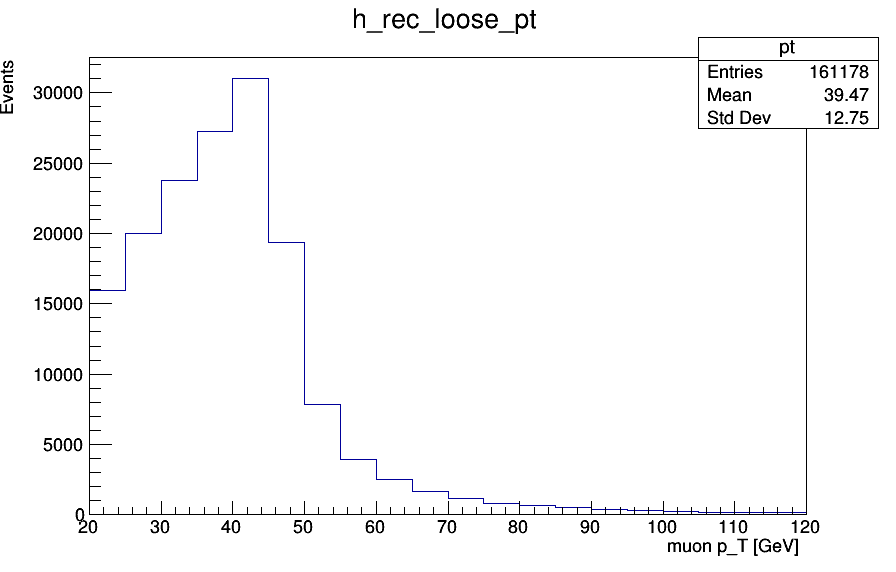

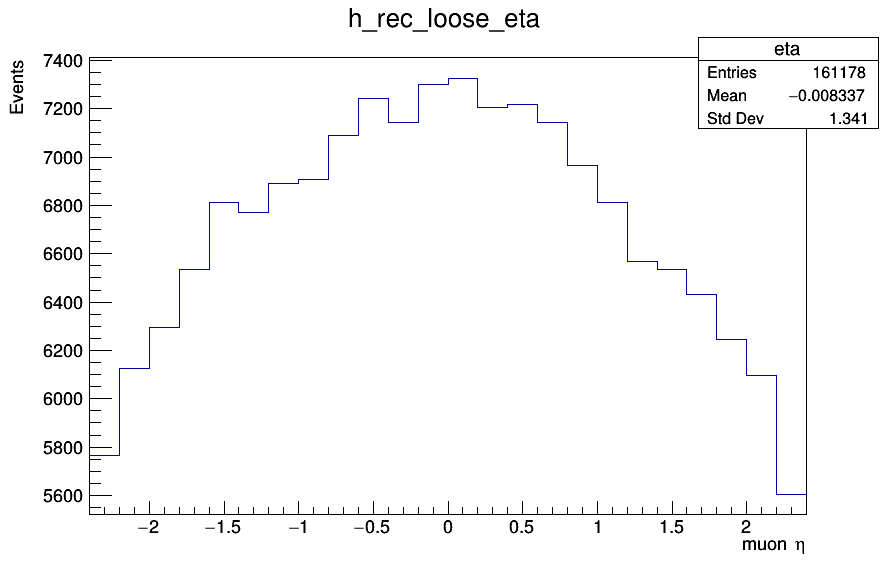

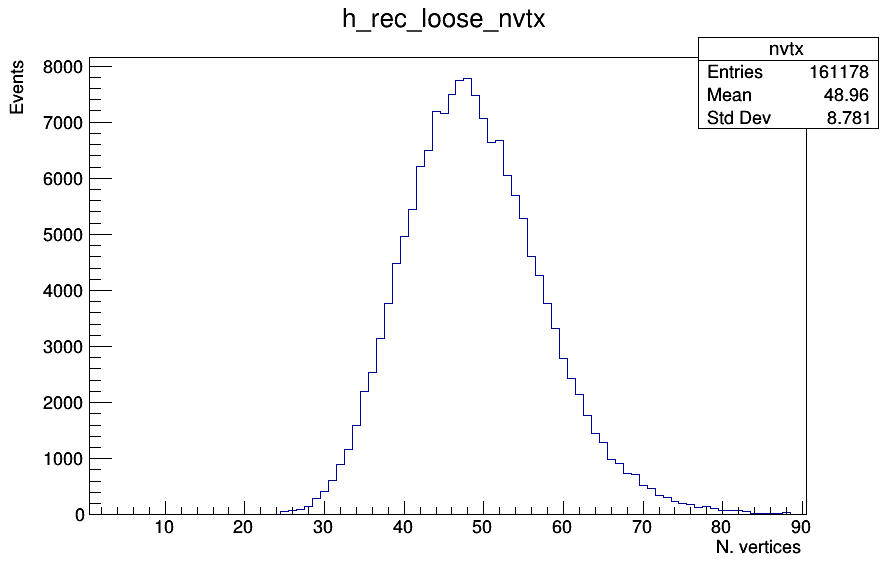

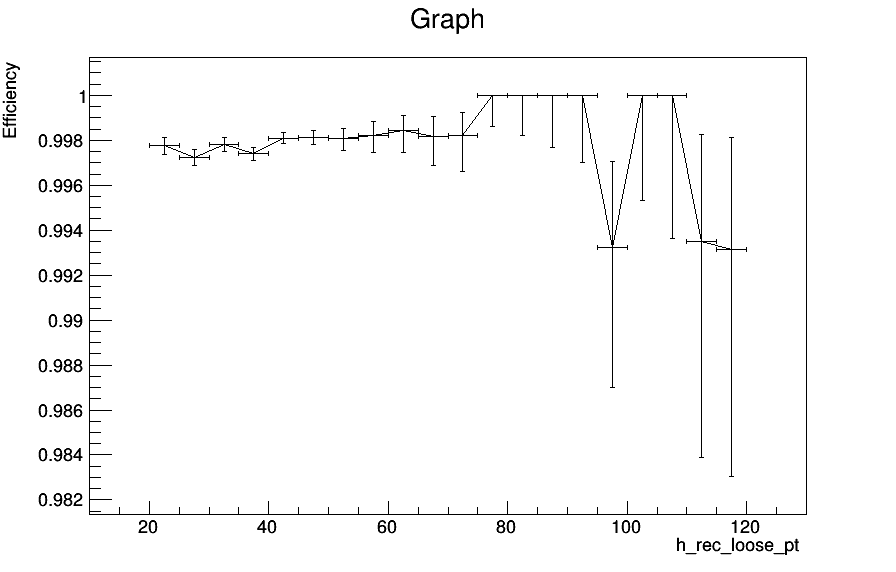

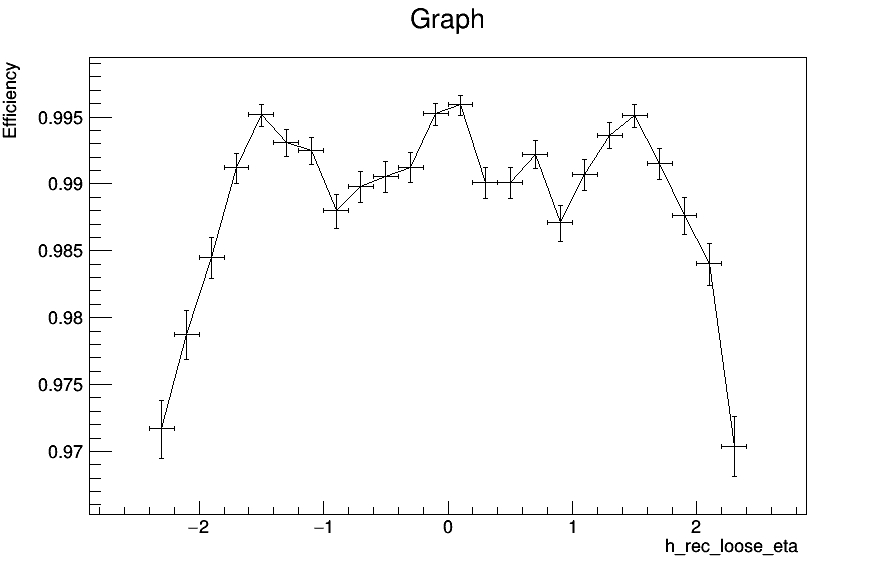

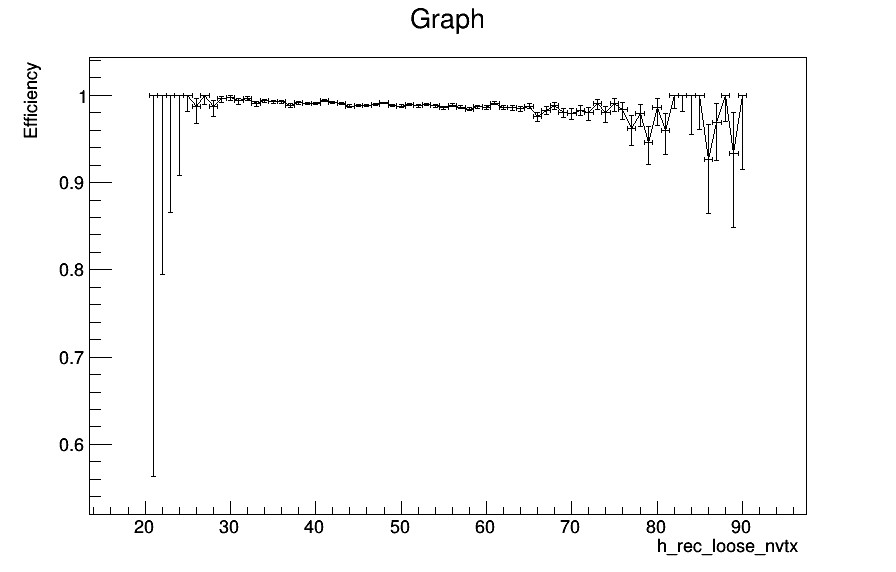

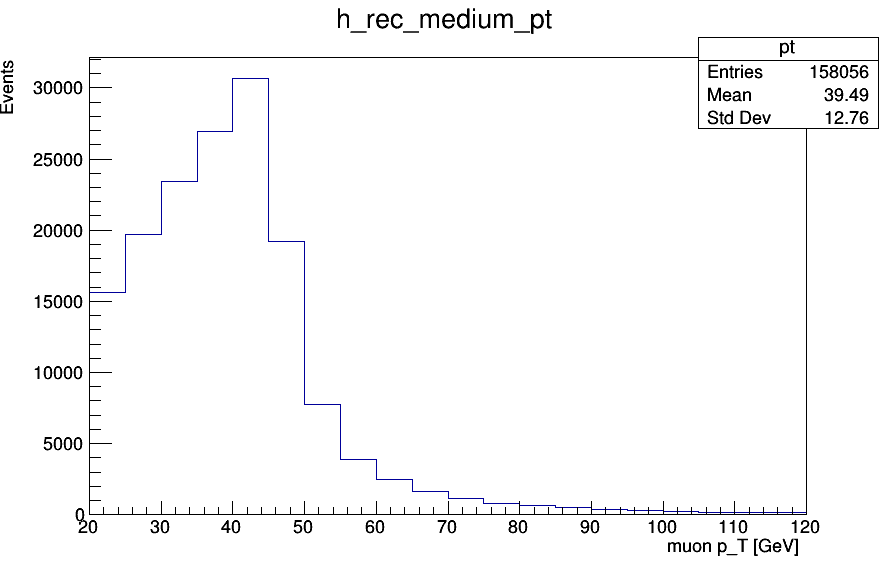

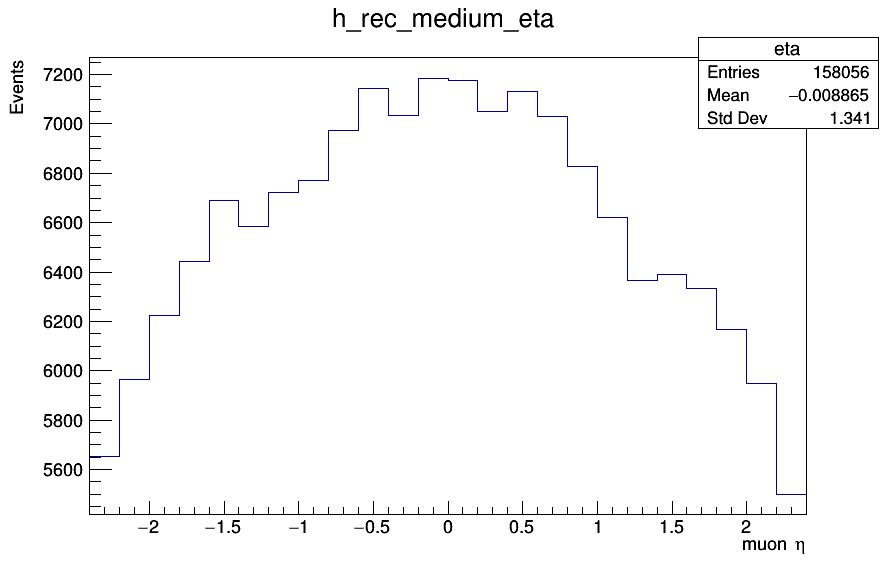

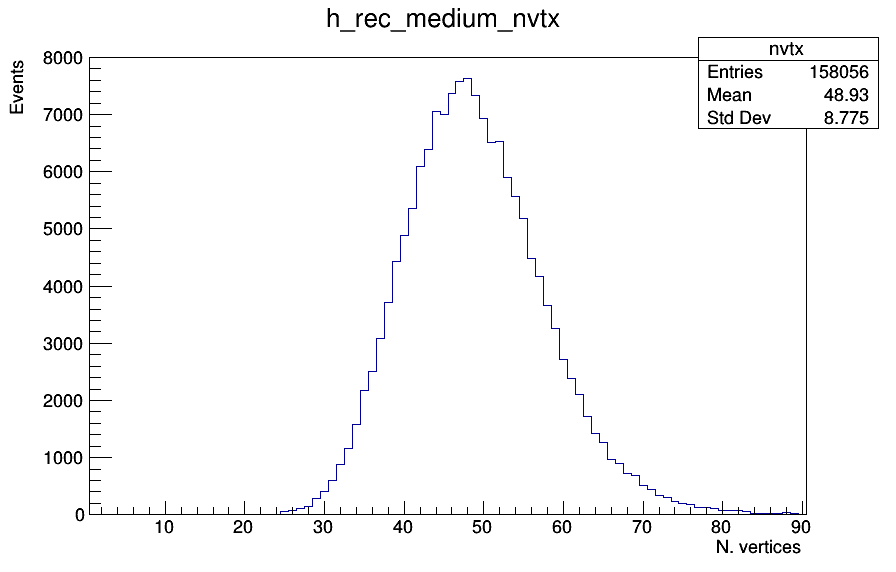

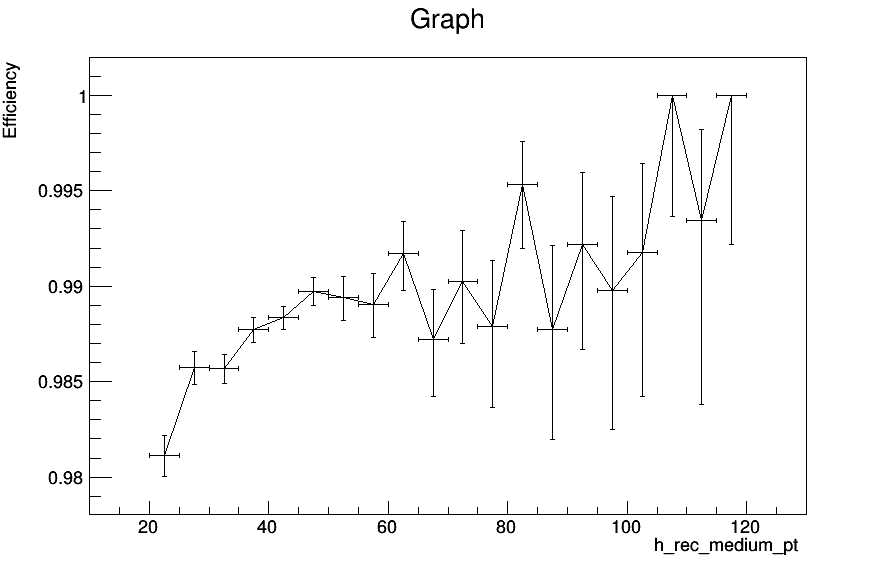

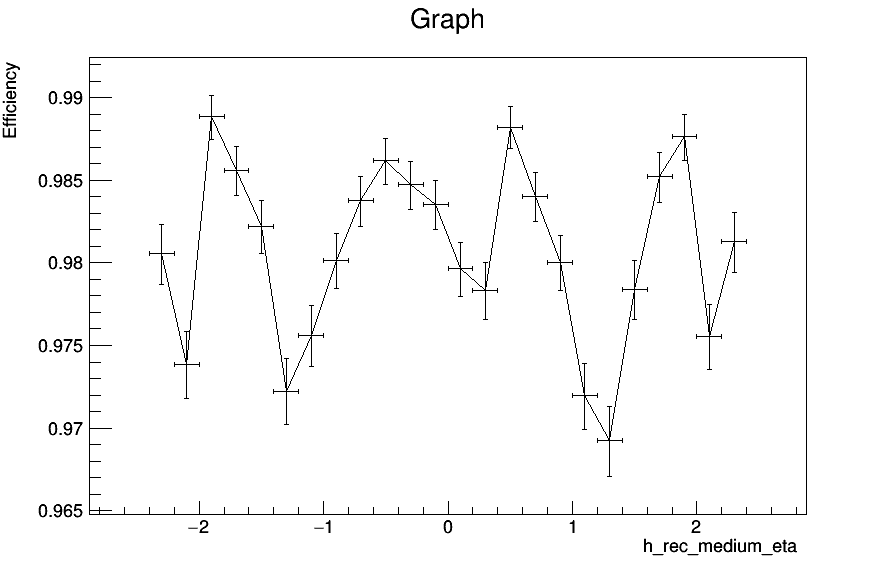

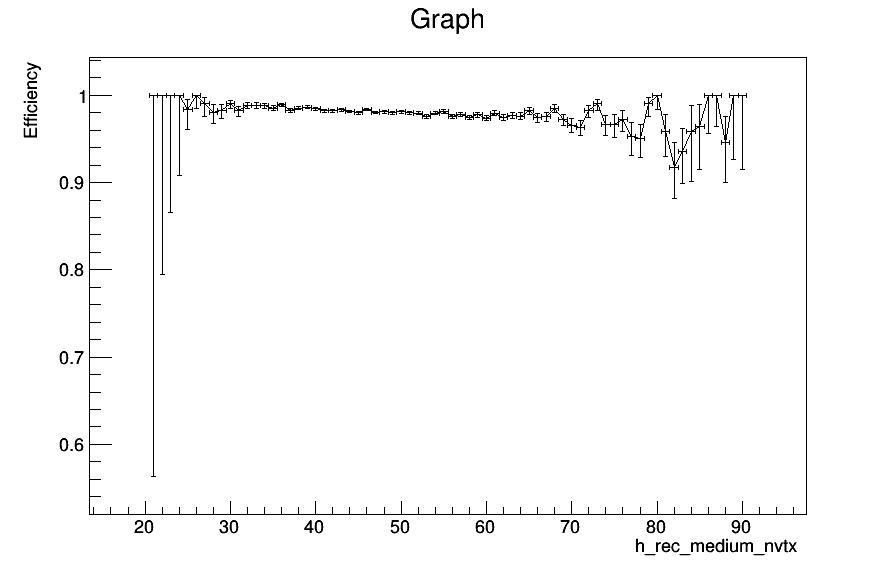

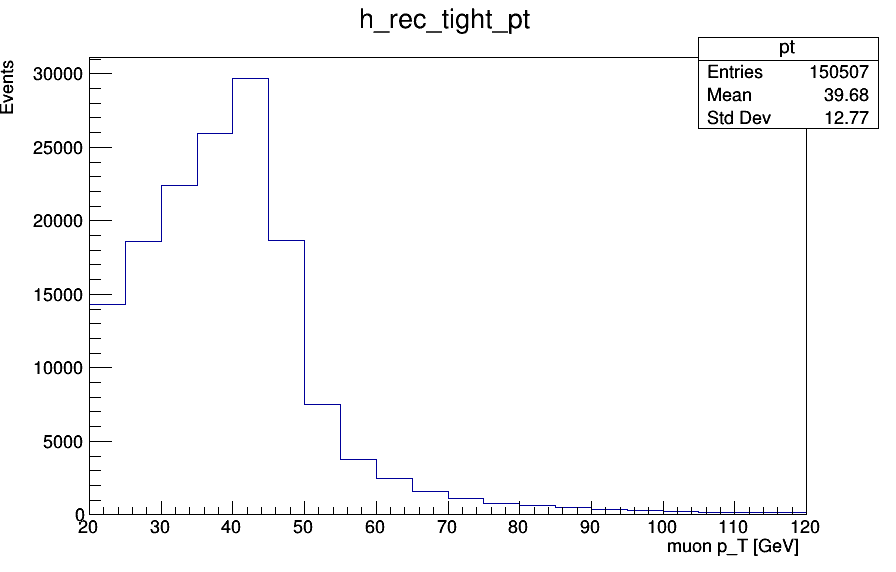

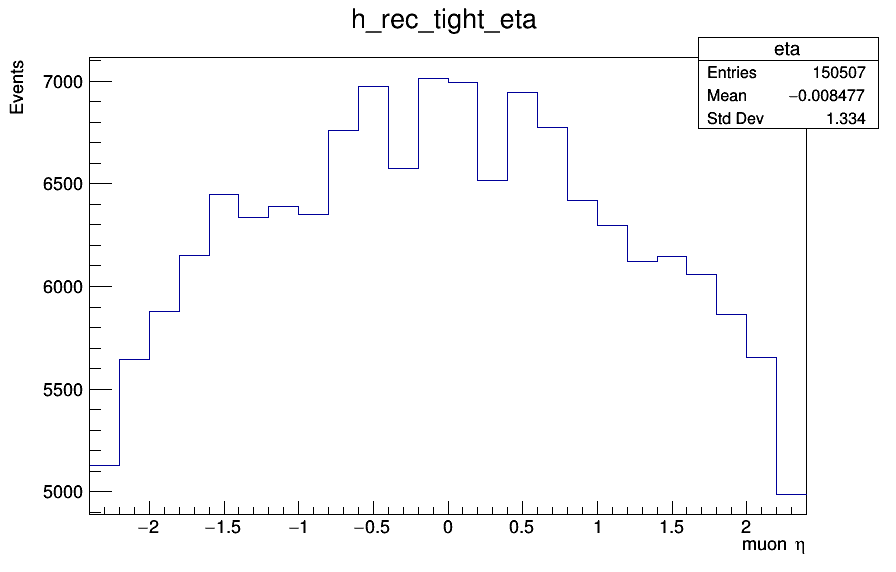

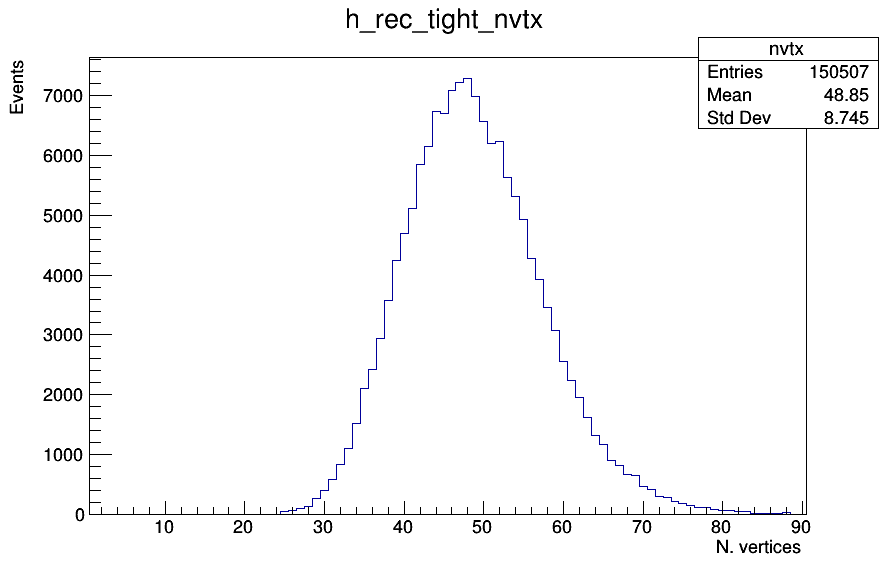

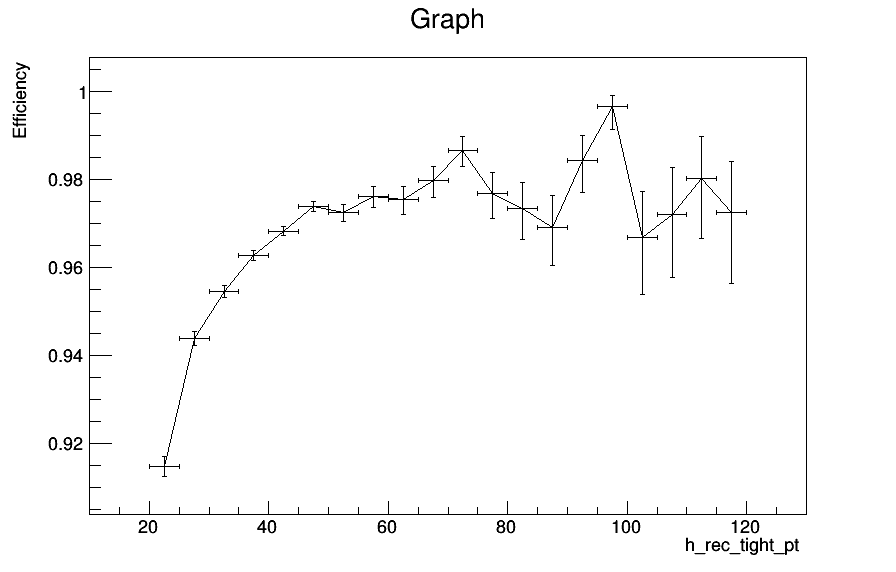

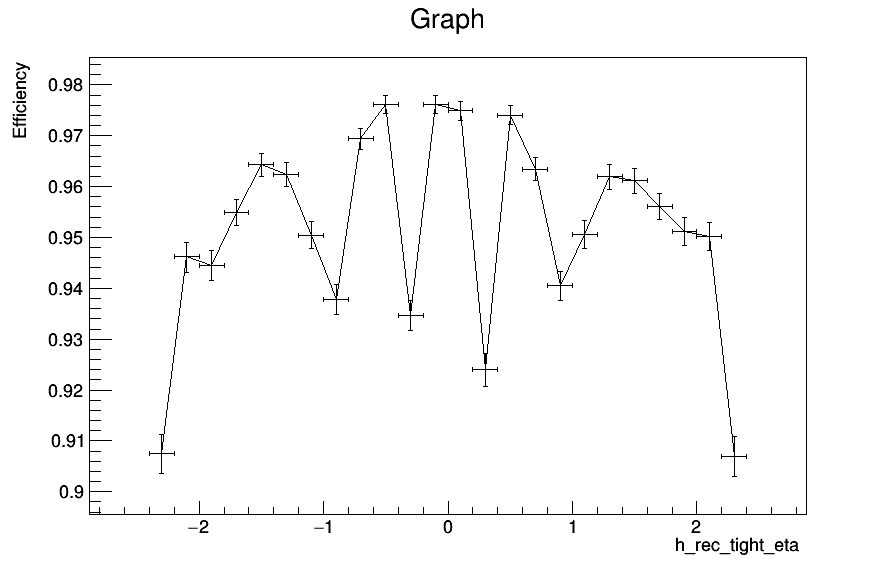

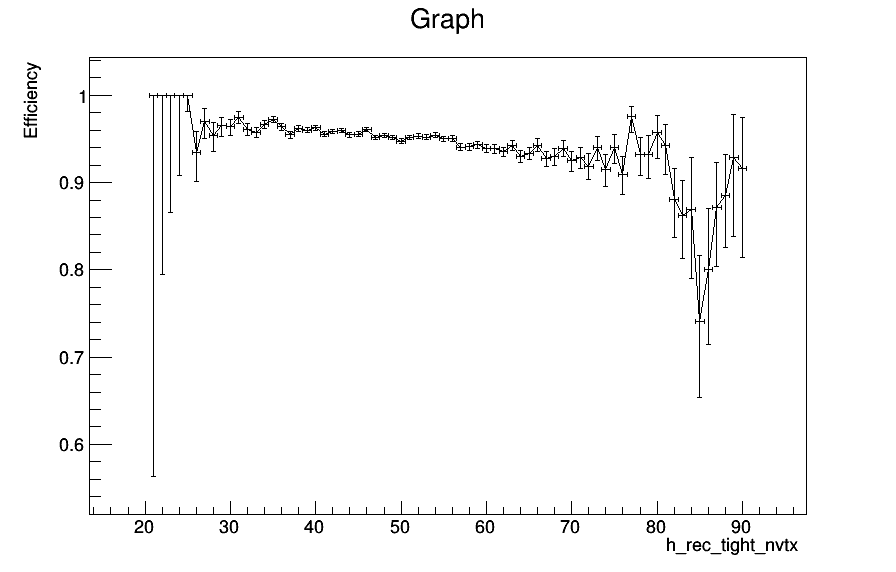

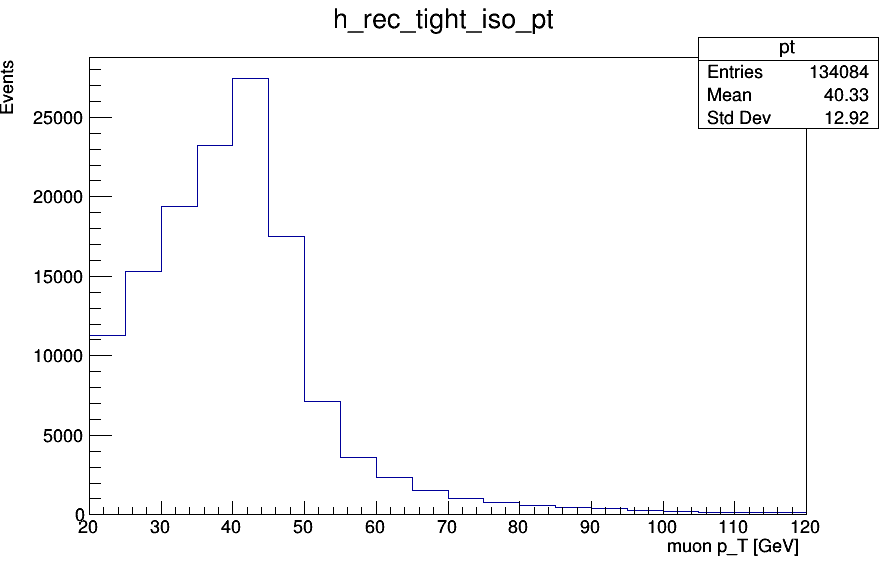

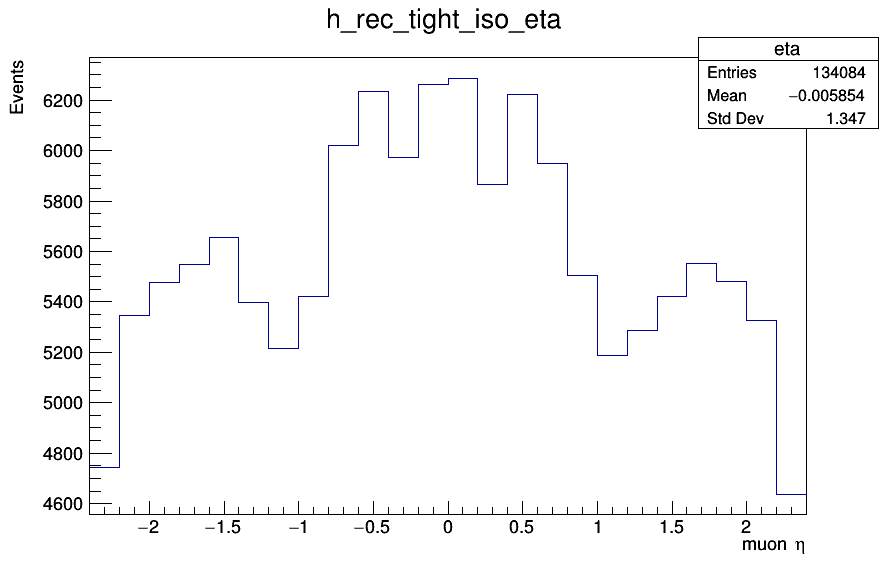

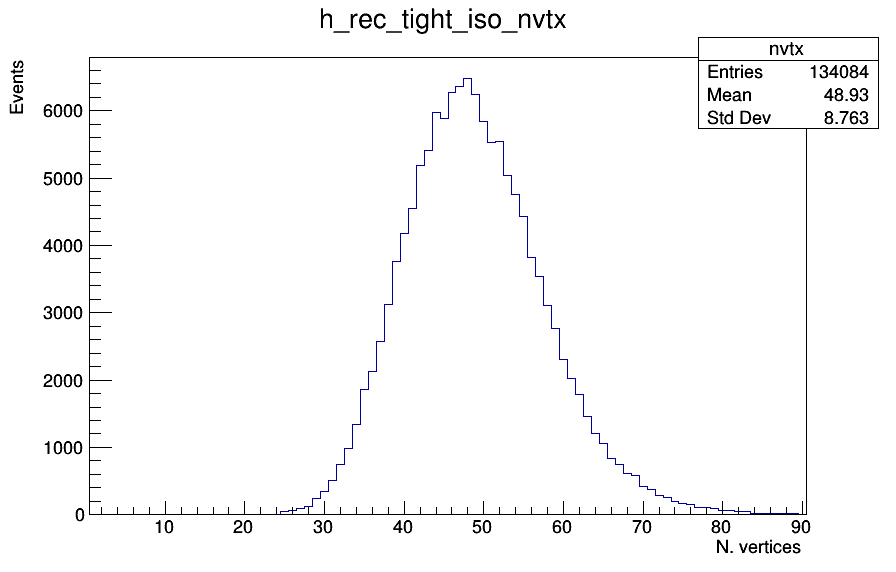

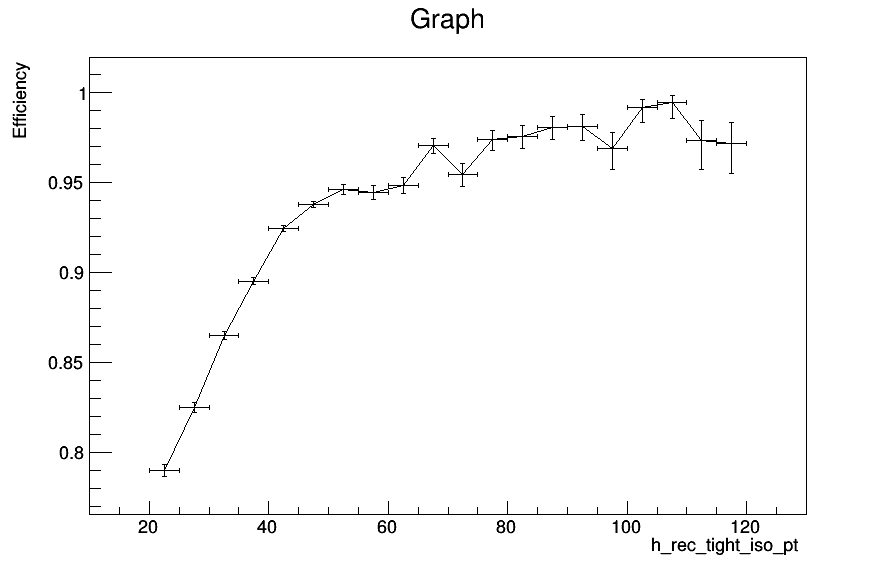

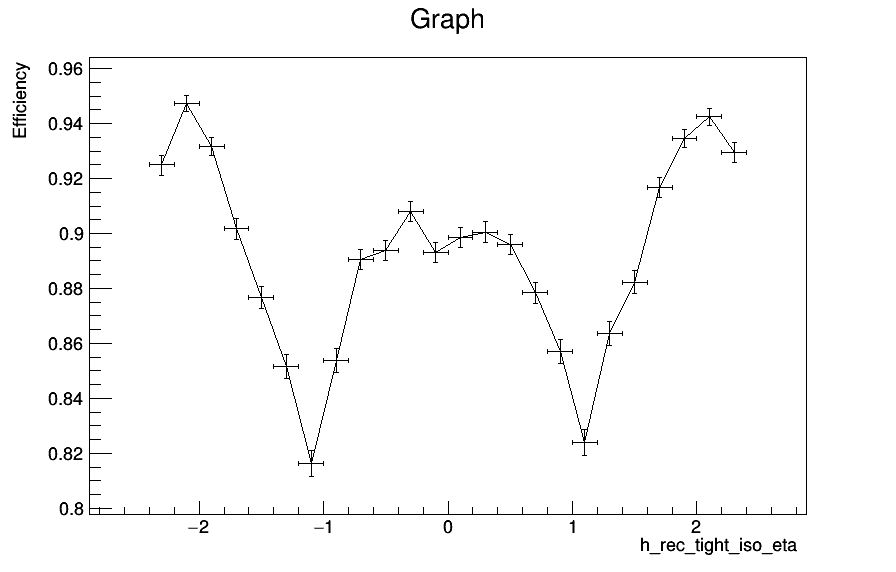

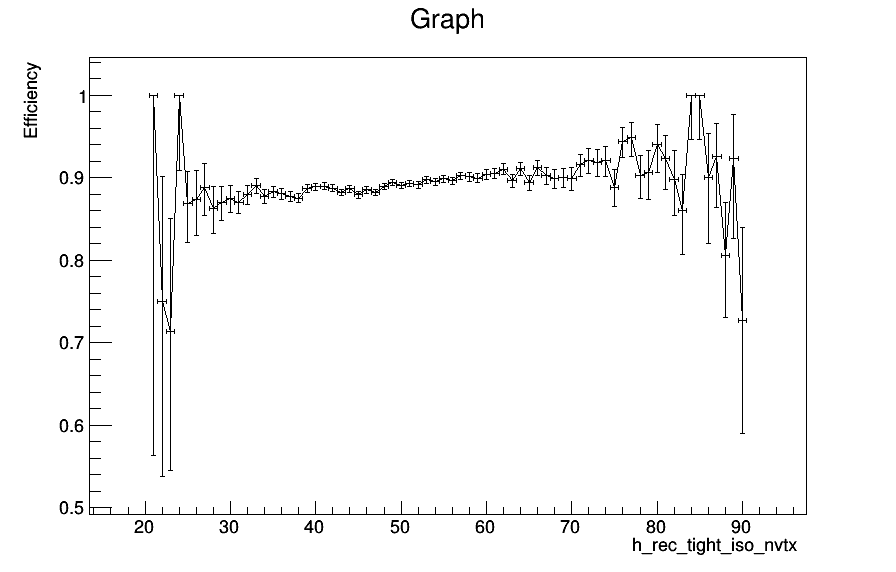

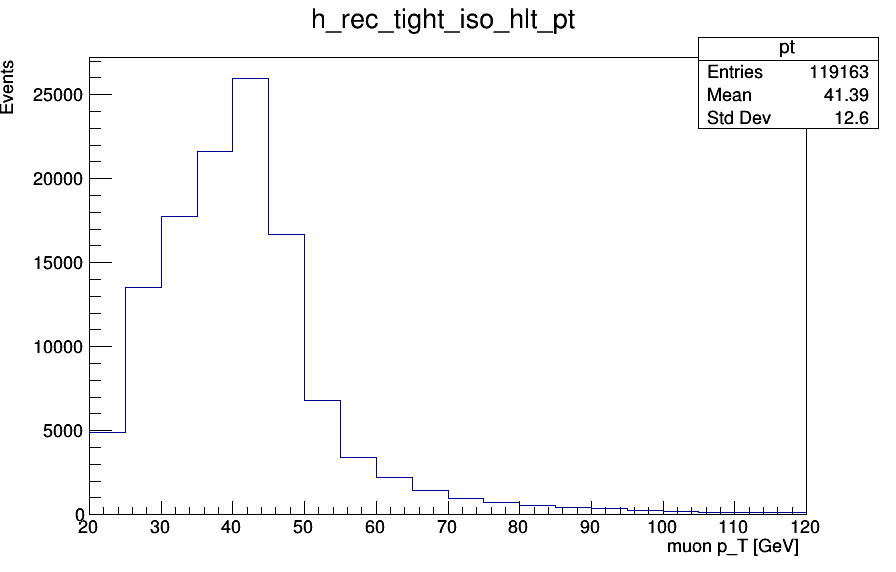

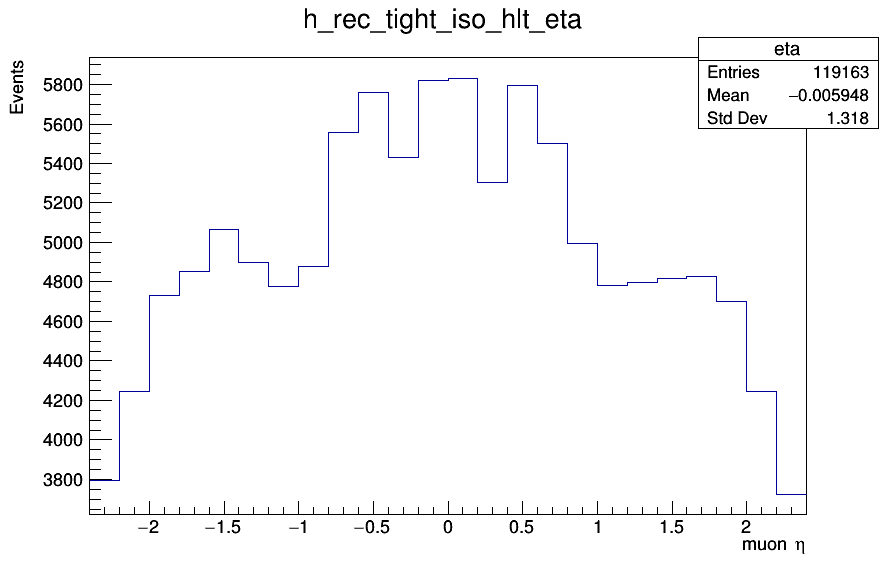

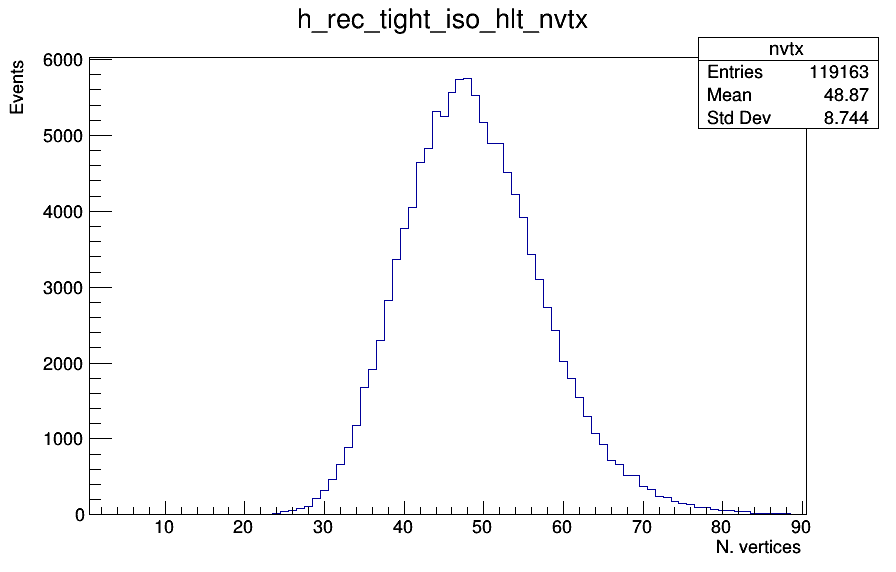

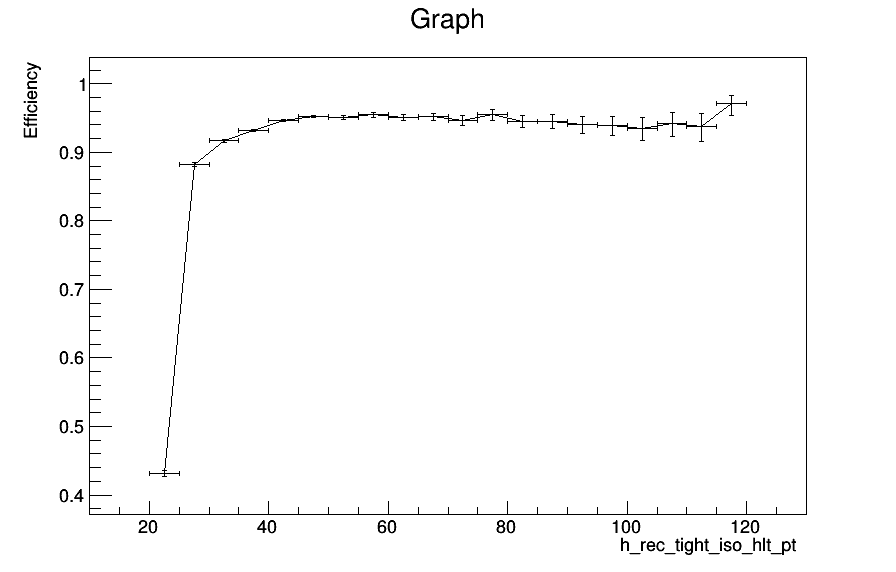

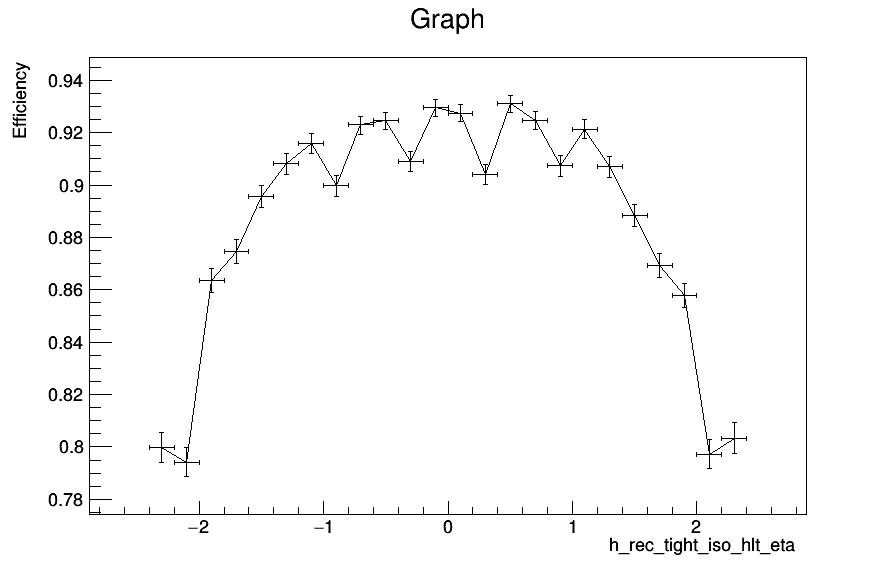

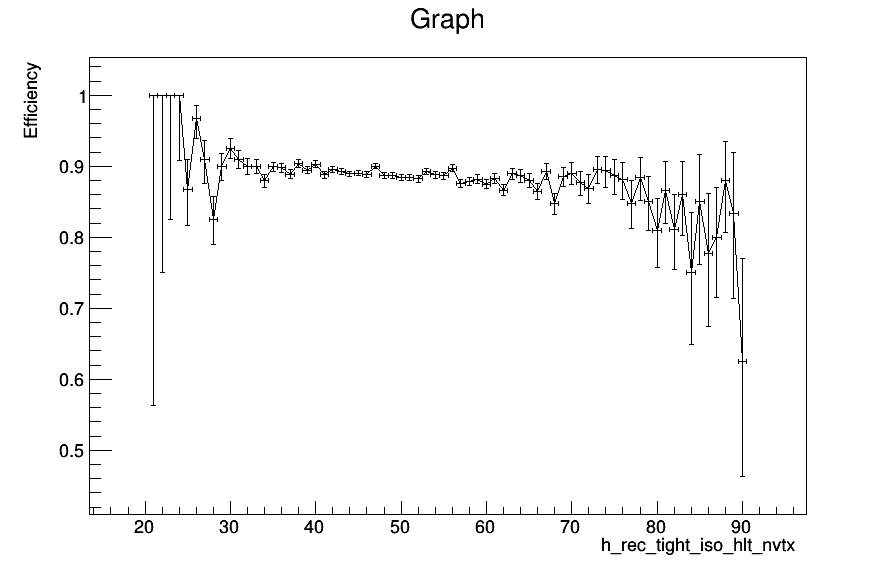

In [285]:
th1dic={}
efficiencydic={}
for name in ['gen', 'rec', 'rec_loose', 'rec_medium', 'rec_tight', 'rec_tight_iso', 'rec_tight_iso_hlt']:
    if name== 'gen':
        th1dic[f'h_{name}_pt']=ROOT.TH1D("pt"  , f'h_{name}_pt;muon p_T [GeV];Events',  20,  20.0, 120.0)
        TH1_fill_and_plot(th1dic[f'h_{name}_pt'], gen_muon.pt, f'h_{name}_pt')
        th1dic[f'h_{name}_eta']=ROOT.TH1D("eta" , f'h_{name}_eta;muon #eta;Events',  24,  -2.4,   2.4)
        TH1_fill_and_plot(th1dic[f'h_{name}_eta'], gen_muon.eta, f'h_{name}_eta')
        th1dic[f'h_{name}_nvtx'] =ROOT.TH1D("nvtx", f'h_{name}_nvtx;N. vertices;Events',  90,   0.5,  90.5)
        TH1_fill_and_plot(th1dic[f'h_{name}_nvtx'], gen_muon.npv, f'h_{name}_nvtx')
        
        name2=name
        continue
        
    if name== 'rec_tight_iso_hlt':
        th1dic[f'h_{name}_pt']=ROOT.TH1D("pt"  , f'h_{name}_pt;muon p_T [GeV];Events',  20,  20.0, 120.0)
        TH1_fill_and_plot(th1dic[f'h_{name}_pt'], muon.muon_pt[muon_mask[f'{name}']][event_mask_goodpv_HLT_isomu24], f'h_{name}_pt')
        th1dic[f'h_{name}_eta']=ROOT.TH1D("eta" , f'h_{name}_eta;muon #eta;Events',  24,  -2.4,   2.4)
        TH1_fill_and_plot(th1dic[f'h_{name}_eta'], muon.muon_eta[muon_mask[f'{name}']][event_mask_goodpv_HLT_isomu24], f'h_{name}_eta')
        th1dic[f'h_{name}_nvtx'] =ROOT.TH1D("nvtx", f'h_{name}_nvtx;N. vertices;Events',  90,   0.5,  90.5)
        TH1_fill_and_plot(th1dic[f'h_{name}_nvtx'], muon.pv_npvsgood[muon_mask[f'{name}']][event_mask_goodpv_HLT_isomu24], f'h_{name}_nvtx')

        nbinpt   = th1dic['h_rec_pt'].GetNbinsX() 
        nbineta  = th1dic['h_rec_eta'].GetNbinsX() 
        nbinnvtx = th1dic['h_rec_nvtx'].GetNbinsX()
        
        efficiencydic[f'gae_{name}_pt']   = ROOT.TGraphAsymmErrors(nbinpt  ) 
        efficiencydic[f'gae_{name}_pt'].SetName(f'gae_{name}_pt')
        efficiencydic[f'gae_{name}_pt'].GetXaxis().SetTitle(f'h_{name}_pt')
        efficiencydic[f'gae_{name}_pt'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_pt'].Divide(th1dic[f'h_{name}_pt']  , th1dic[f'h_{name2}_pt']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_pt'], f'gae_{name}_pt')
        
        efficiencydic[f'gae_{name}_eta']   = ROOT.TGraphAsymmErrors(nbineta ) 
        efficiencydic[f'gae_{name}_eta'].SetName(f'gae_{name}_pt')
        efficiencydic[f'gae_{name}_eta'].GetXaxis().SetTitle(f'h_{name}_eta')
        efficiencydic[f'gae_{name}_eta'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_eta'].Divide(th1dic[f'h_{name}_eta']  , th1dic[f'h_{name2}_eta']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_eta'], f'gae_{name}_eta')
        
        efficiencydic[f'gae_{name}_nvtx']   = ROOT.TGraphAsymmErrors(nbinnvtx ) 
        efficiencydic[f'gae_{name}_nvtx'].SetName(f'gae_{name}_nvtx')
        efficiencydic[f'gae_{name}_nvtx'].GetXaxis().SetTitle(f'h_{name}_nvtx')
        efficiencydic[f'gae_{name}_nvtx'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_nvtx'].Divide(th1dic[f'h_{name}_nvtx']  , th1dic[f'h_{name2}_nvtx']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_nvtx'], f'gae_{name}_nvtx')
        
        name2=name
    else:
        th1dic[f'h_{name}_pt']=ROOT.TH1D("pt"  , f'h_{name}_pt;muon p_T [GeV];Events',  20,  20.0, 120.0)
        TH1_fill_and_plot(th1dic[f'h_{name}_pt'], muon.muon_pt[muon_mask[f'{name}']][event_mask_goodpv], f'h_{name}_pt')
        th1dic[f'h_{name}_eta']=ROOT.TH1D("eta" , f'h_{name}_eta;muon #eta;Events',  24,  -2.4,   2.4)
        TH1_fill_and_plot(th1dic[f'h_{name}_eta'], muon.muon_eta[muon_mask[f'{name}']][event_mask_goodpv], f'h_{name}_eta')
        th1dic[f'h_{name}_nvtx'] =ROOT.TH1D("nvtx", f'h_{name}_nvtx;N. vertices;Events',  90,   0.5,  90.5)
        TH1_fill_and_plot(th1dic[f'h_{name}_nvtx'], muon.pv_npvsgood[muon_mask[f'{name}']][event_mask_goodpv], f'h_{name}_nvtx')
        
        nbinpt   = th1dic['h_rec_pt'].GetNbinsX() 
        nbineta  = th1dic['h_rec_eta'].GetNbinsX() 
        nbinnvtx = th1dic['h_rec_nvtx'].GetNbinsX()
        
        efficiencydic[f'gae_{name}_pt']   = ROOT.TGraphAsymmErrors(nbinpt  ) 
        efficiencydic[f'gae_{name}_pt'].SetName(f'gae_{name}_pt')
        efficiencydic[f'gae_{name}_pt'].GetXaxis().SetTitle(f'h_{name}_pt')
        efficiencydic[f'gae_{name}_pt'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_pt'].Divide(th1dic[f'h_{name}_pt']  , th1dic[f'h_{name2}_pt']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_pt'], f'gae_{name}_pt')
        
        efficiencydic[f'gae_{name}_eta']   = ROOT.TGraphAsymmErrors(nbineta ) 
        efficiencydic[f'gae_{name}_eta'].SetName(f'gae_{name}_pt')
        efficiencydic[f'gae_{name}_eta'].GetXaxis().SetTitle(f'h_{name}_eta')
        efficiencydic[f'gae_{name}_eta'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_eta'].Divide(th1dic[f'h_{name}_eta']  , th1dic[f'h_{name2}_eta']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_eta'], f'gae_{name}_eta')
        
        efficiencydic[f'gae_{name}_nvtx']   = ROOT.TGraphAsymmErrors(nbinnvtx ) 
        efficiencydic[f'gae_{name}_nvtx'].SetName(f'gae_{name}_nvtx')
        efficiencydic[f'gae_{name}_nvtx'].GetXaxis().SetTitle(f'h_{name}_nvtx')
        efficiencydic[f'gae_{name}_nvtx'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_nvtx'].Divide(th1dic[f'h_{name}_nvtx']  , th1dic[f'h_{name2}_nvtx']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_nvtx'], f'gae_{name}_nvtx')
        
        name2=name



# Step 2

In [287]:
tag_muon_mask=(muon.genpart_pt>25)& (abs(muon.genpart_eta)<2.4)& (muon.muon_tightid==1)& (muon.muon_dz<0.1)& (muon.muon_pfreliso04_all< 0.12)& trigger_match_mask

In [293]:
tag_muon=ak.JaggedArray.zip(pt= muon.muon_pt[tag_muon_mask],
                            eta= muon.muon_eta[tag_muon_mask],
                            phi= muon.muon_phi[tag_muon_mask],
                            mass= muon.muon_mass[tag_muon_mask],
                            charge= muon.muon_charge[tag_muon_mask])

In [321]:
probe_muon_mask=[]
for tag4s, probe4s, in zip(tag_muon, muon):
    list=[]
    if len(probe4s)==0:
        probe_muon_mask.append([])
        continue
    for probe4 in probe4s:
        bestmass=0
        if len(tag4s)==0:
            list.append(False)
            continue
        for tag4 in tag4s:
            if tag4.charge*probe4.muon_charge>0:
                continue
            mass=sqrt(2*tag4.pt*probe4.muon_pt*(cosh(tag4.eta - probe4.muon_eta) - cos(tag4.phi - probe4.muon_phi)))
            if abs(mass-91.)>5.:
                continue
            else:
                bestmass= mass
                break
        if bestmass!=0:
            list.append(True)
        else:
            list.append(False)
    probe_muon_mask.append(list)
            
            

In [325]:
probe_muon_masking=ak.fromiter(probe_muon_mask)& (muon.genpart_pt>20)& (abs(muon.genpart_eta)<2.4)

In [326]:
probe_muon= ak.JaggedArray.zip(pt= muon.muon_pt[probe_muon_masking],
                               eta= muon.muon_eta[probe_muon_masking],
                               phi= muon.muon_phi[probe_muon_masking],
                               npvs= muon.pv_npvsgood[probe_muon_masking])

SyntaxError: invalid syntax (<ipython-input-329-2e4687ee5e29>, line 1)

In [333]:
muon_mask={}
muon_mask['rec']= probe_muon_masking
muon_mask['rec_loose']= probe_muon_masking& (muon.muon_looseid==1) 
muon_mask['rec_medium']= probe_muon_masking& (muon.muon_mediumid==1) 
muon_mask['rec_tight']=  probe_muon_masking& (muon.muon_tightid==1)
muon_mask['rec_tight_iso']= probe_muon_masking& (muon.muon_tightid==1)& (muon.muon_pfreliso04_all< 0.12)
muon_mask['rec_tight_iso_hlt']= probe_muon_masking& (muon.muon_tightid==1)& (muon.muon_pfreliso04_all< 0.12)& trigger_match_mask

Warning in <TROOT::Append>: Replacing existing TH1: pt (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_rec_pt
Warning in <TROOT::Append>: Replacing existing TH1: eta (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_rec_eta
Warning in <TROOT::Append>: Replacing existing TH1: nvtx (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_rec_nvtx
Warning in <TROOT::Append>: Replacing existing TH1: pt (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_rec_loose_pt
Warning in <TROOT::Append>: Replacing existing TH1: eta (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_rec_loose_eta
Warning in <TROOT::Append>: Replacing existing TH1: nvtx (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_rec_loose_nvtx
Warning in <TCanvas::Constructor>:

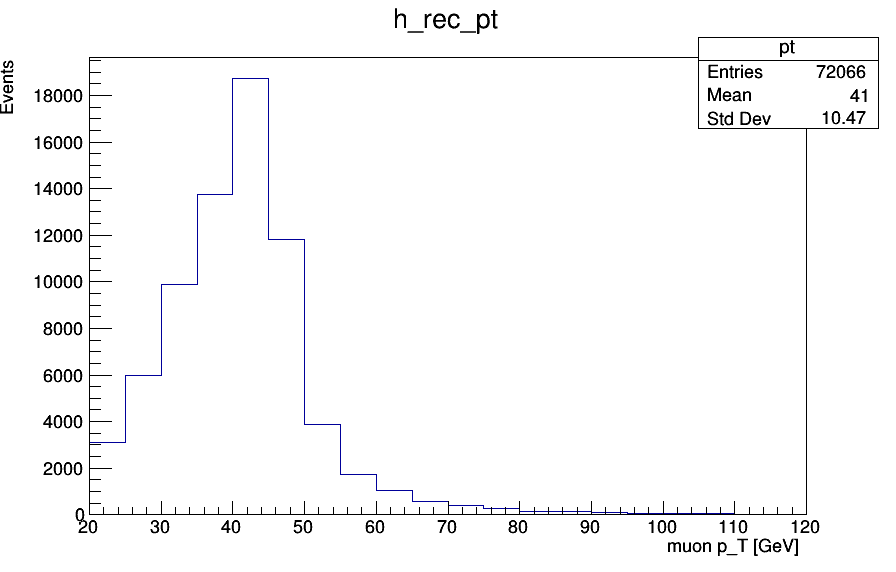

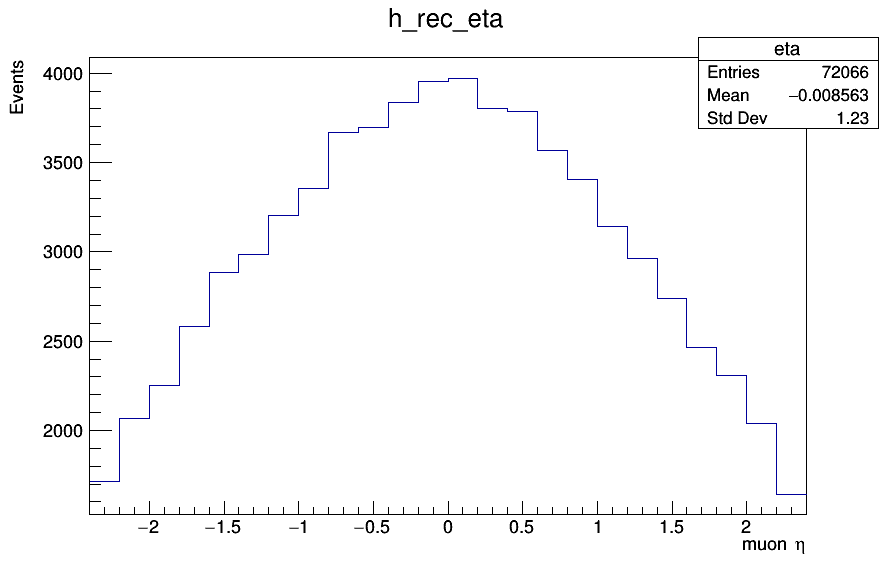

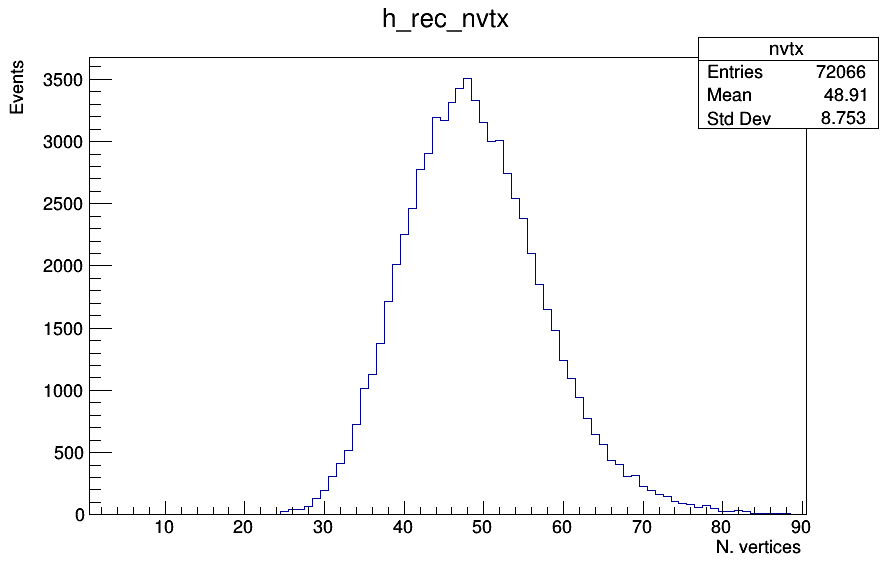

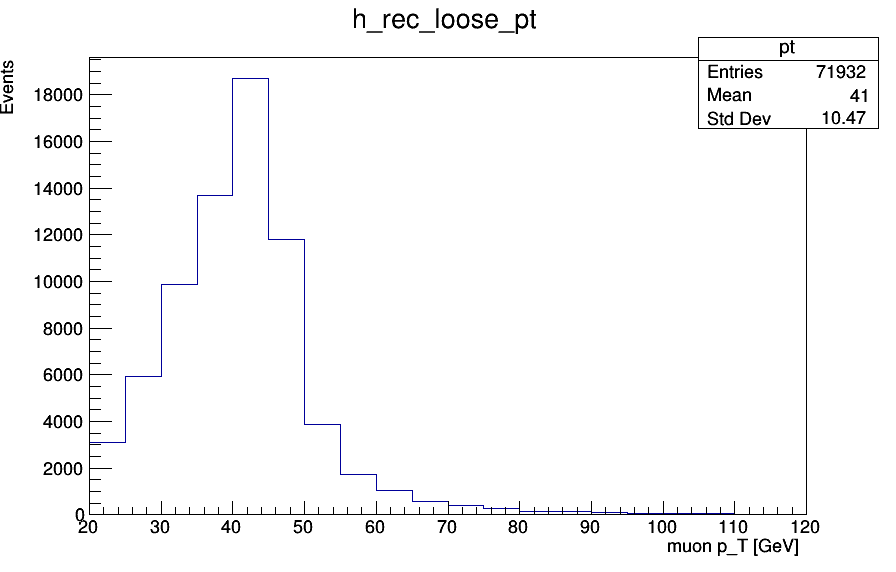

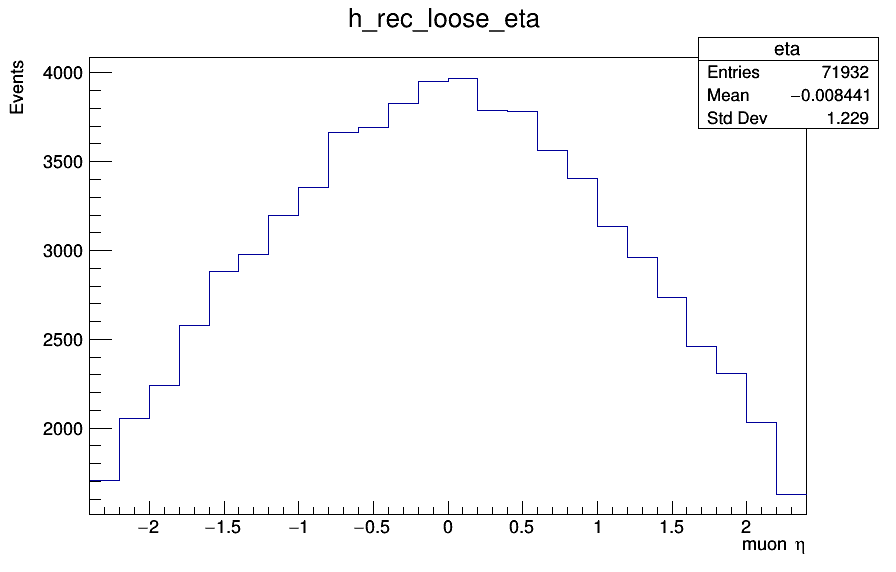

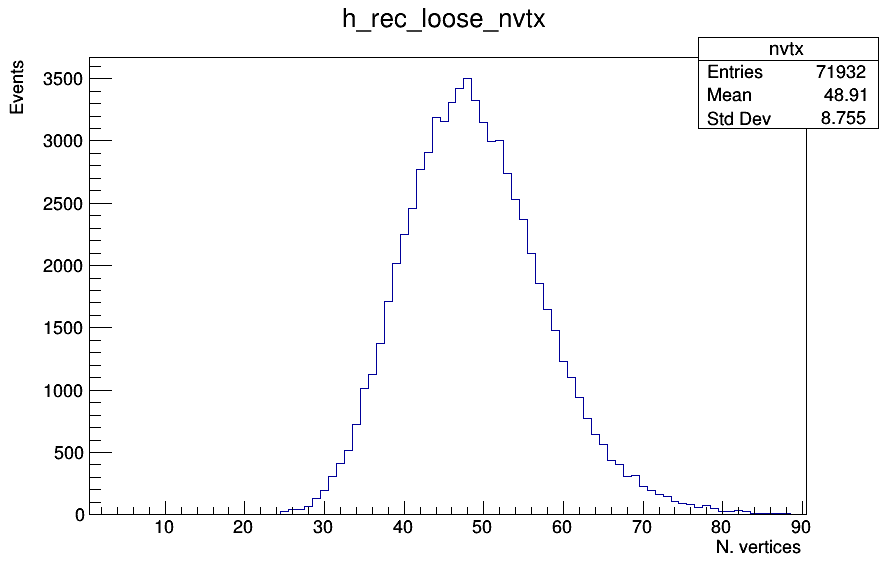

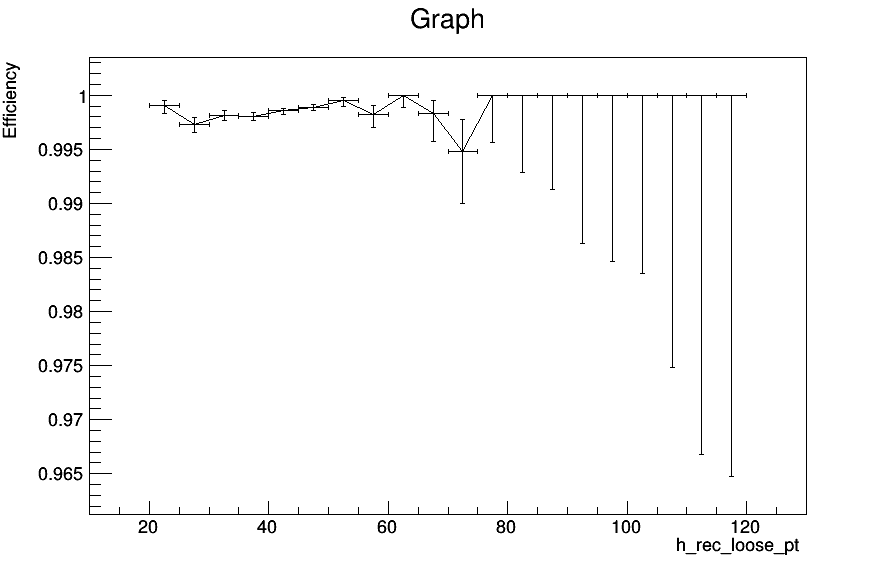

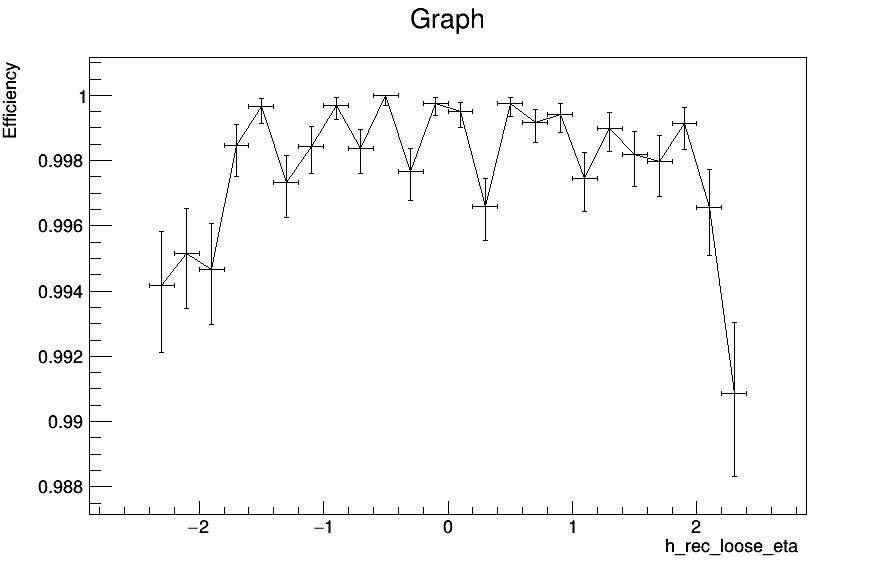

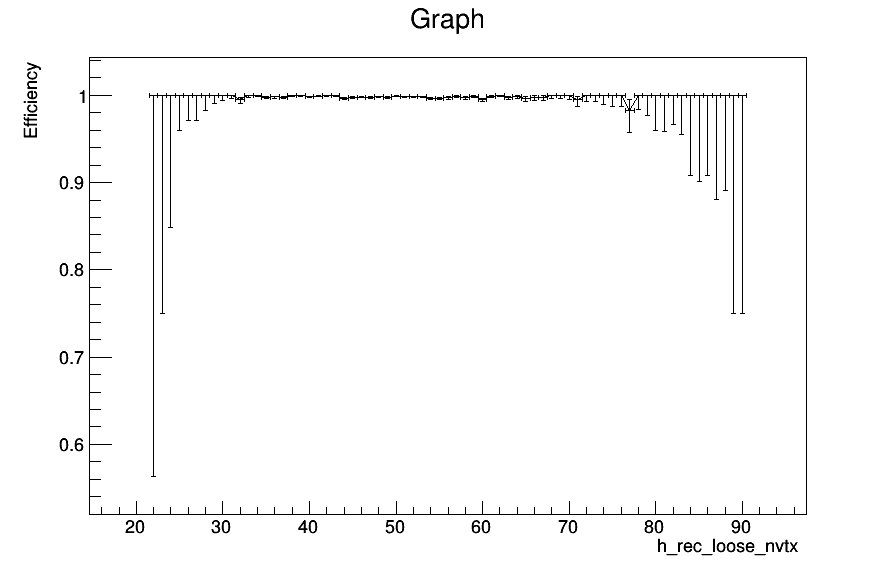

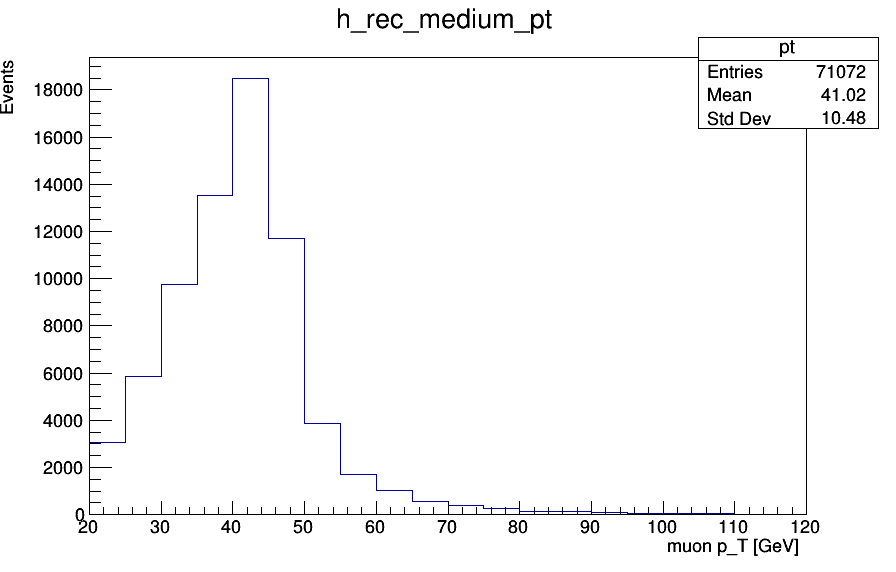

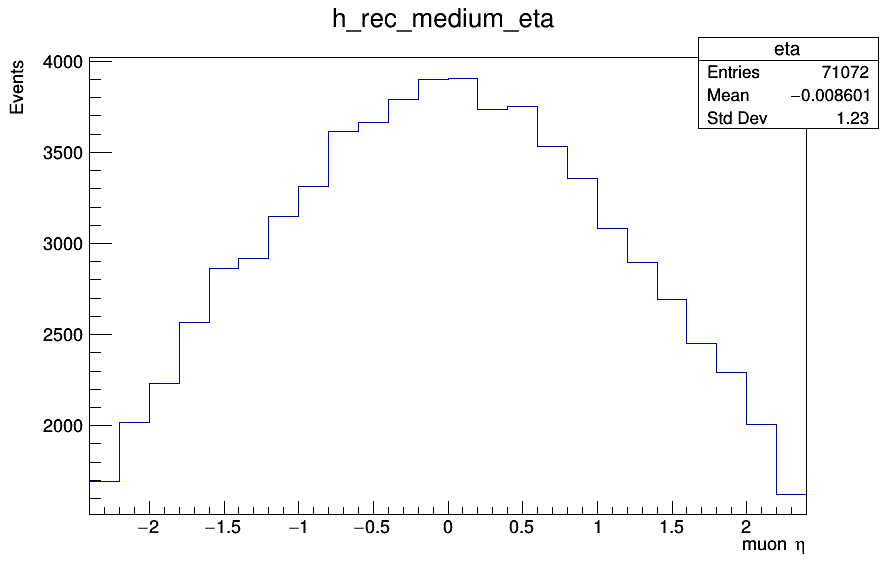

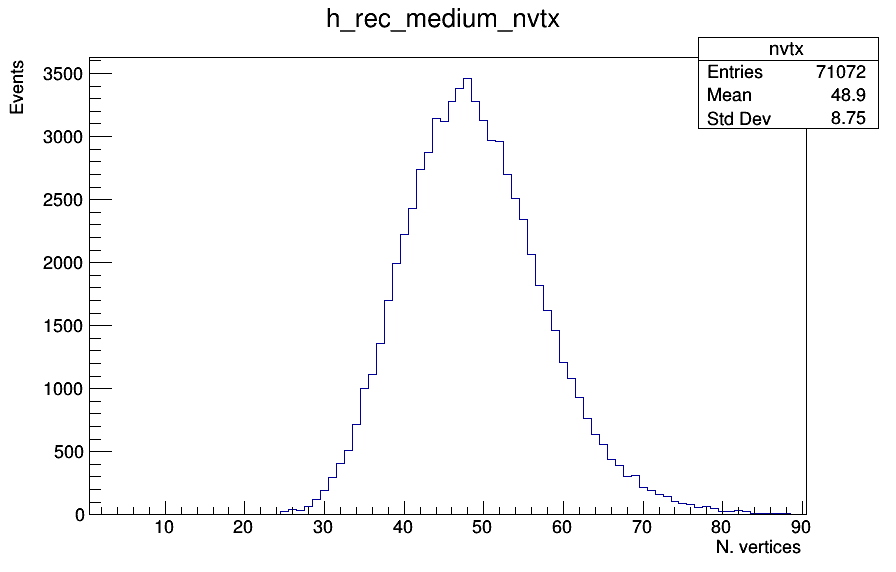

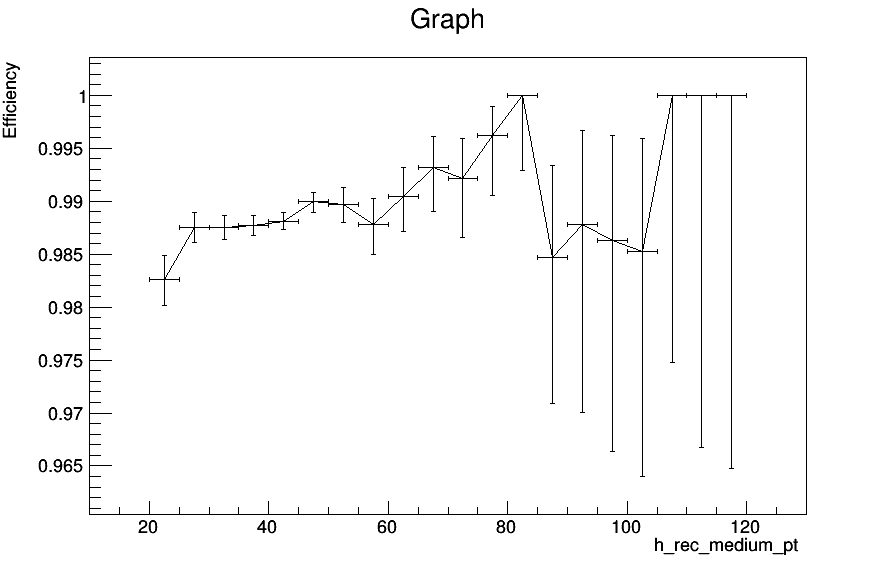

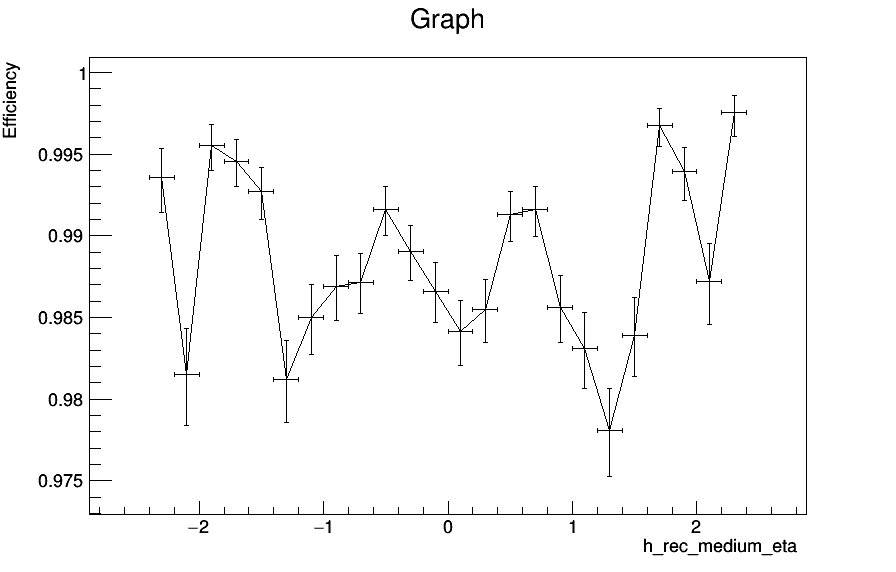

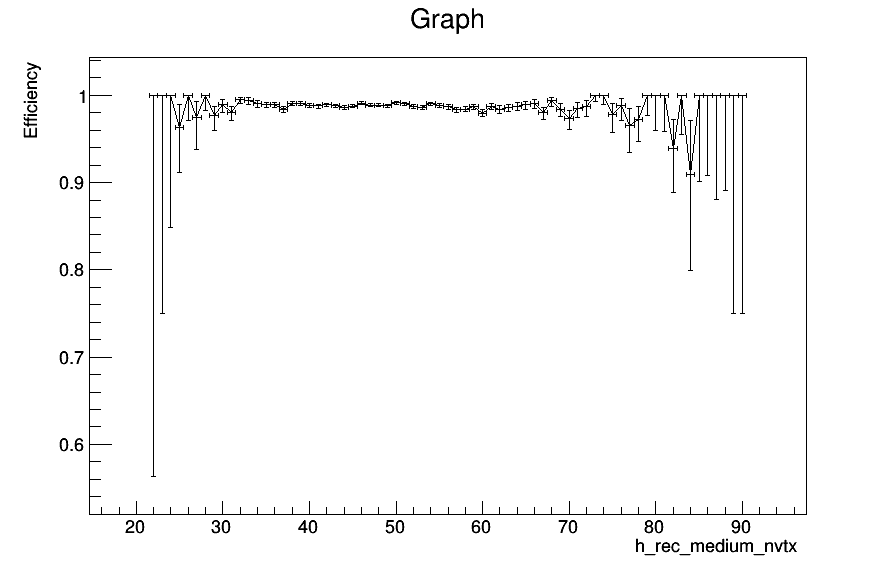

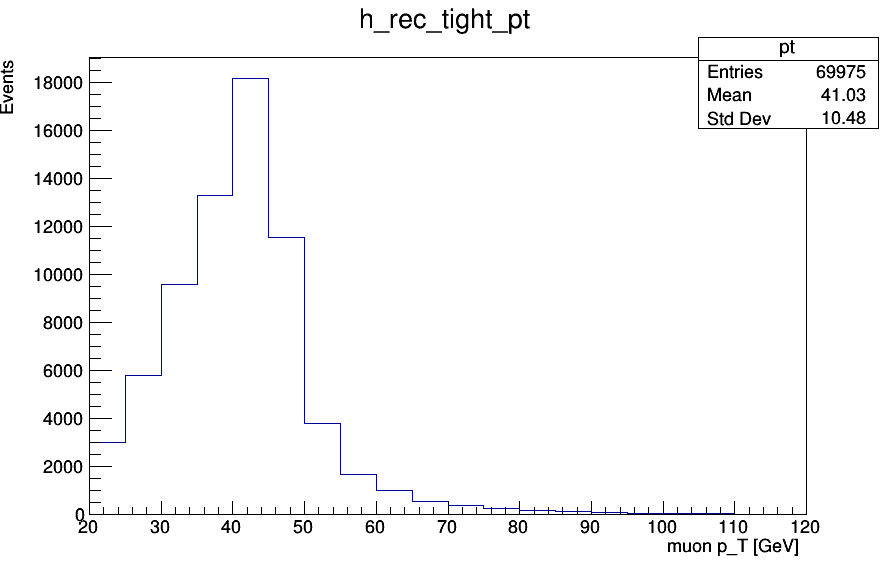

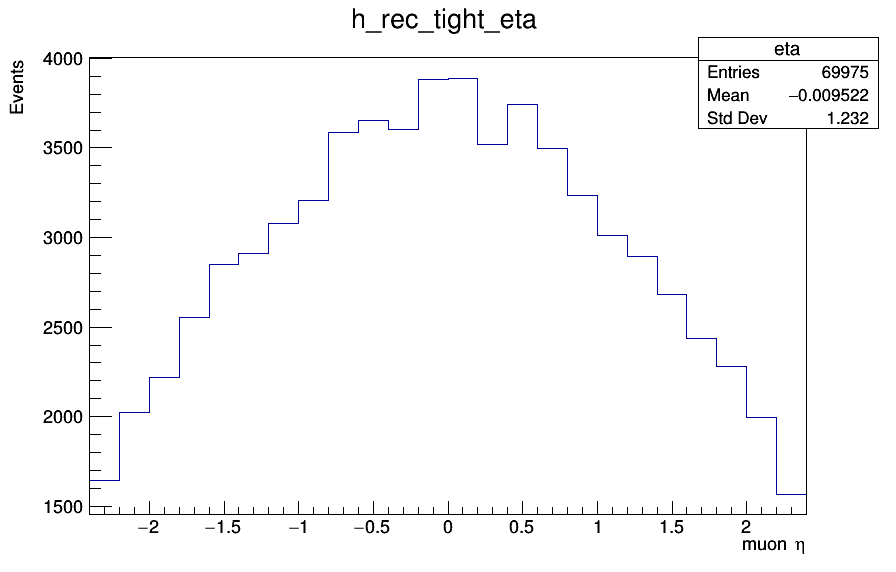

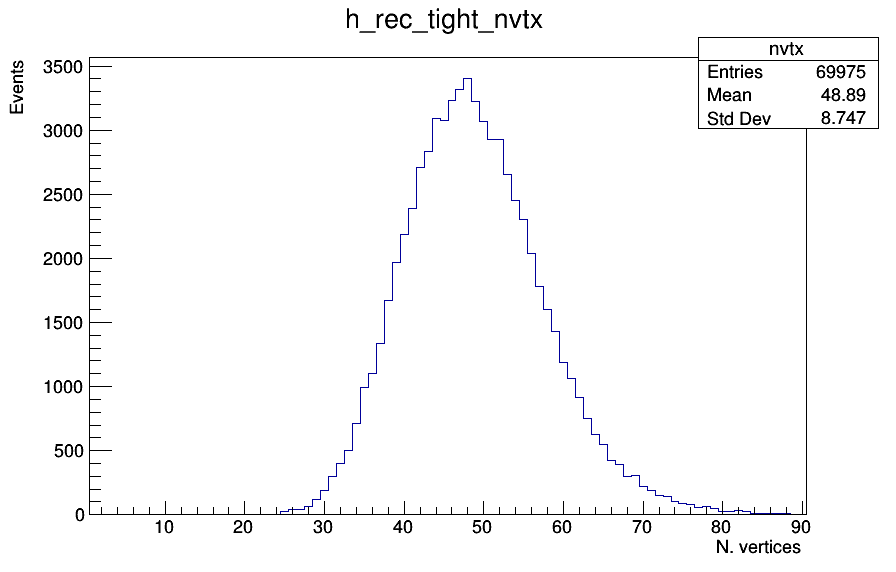

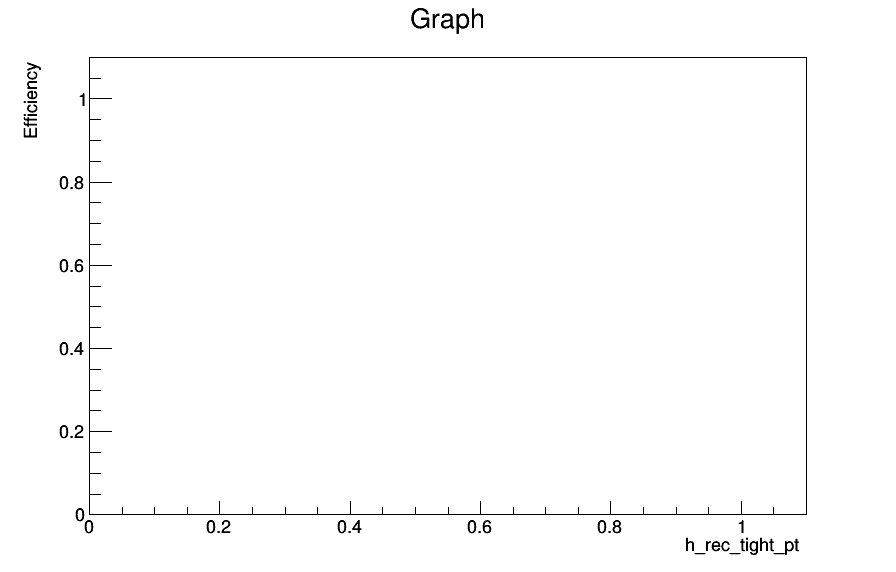

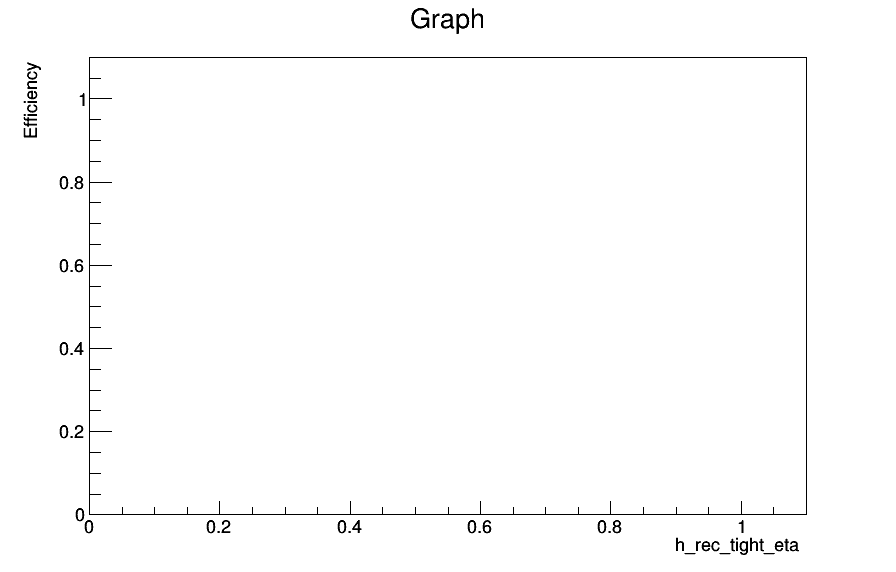

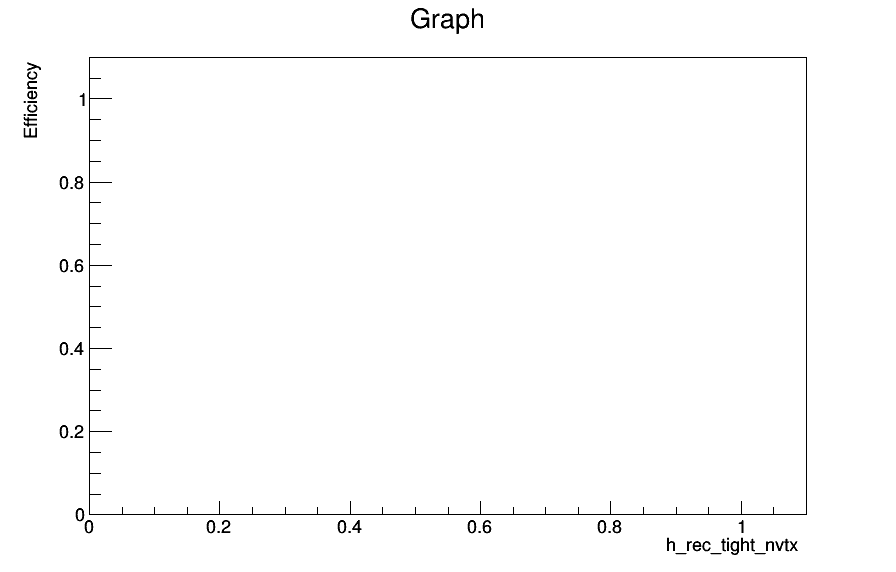

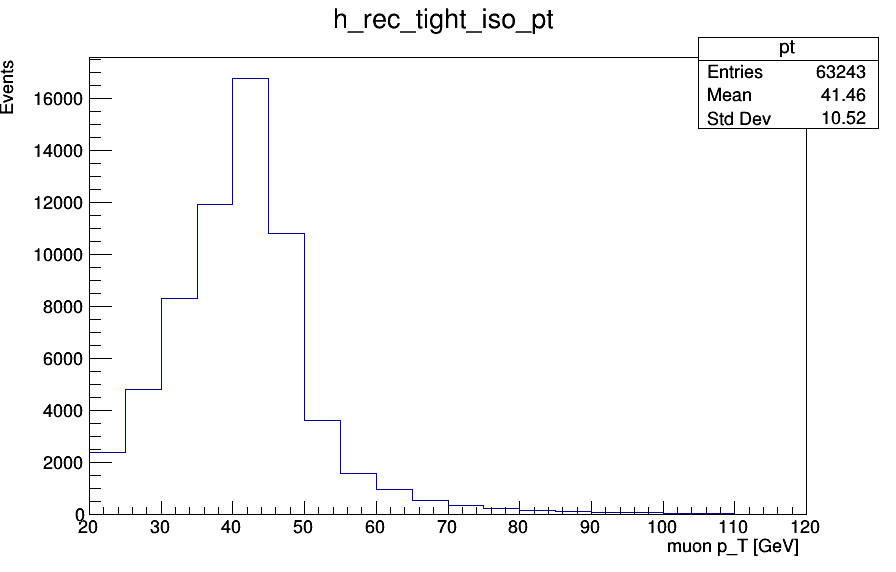

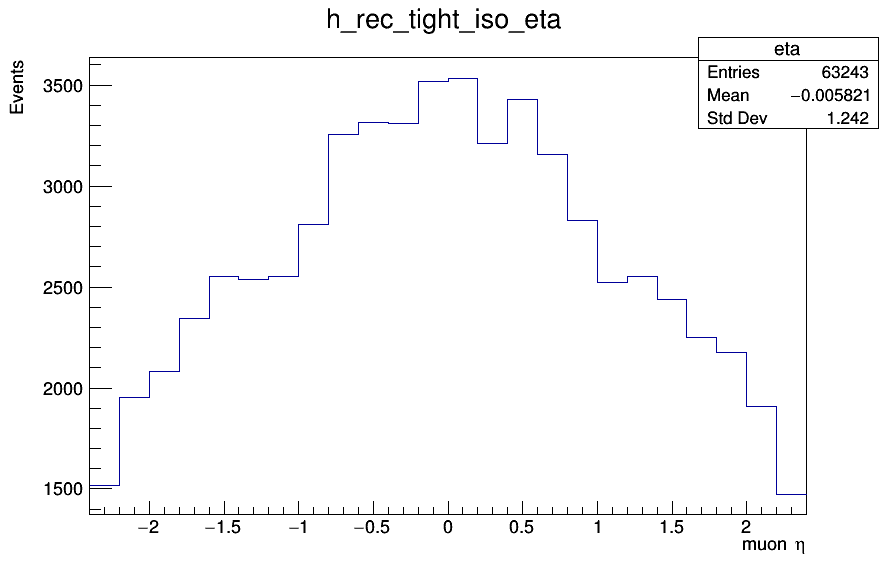

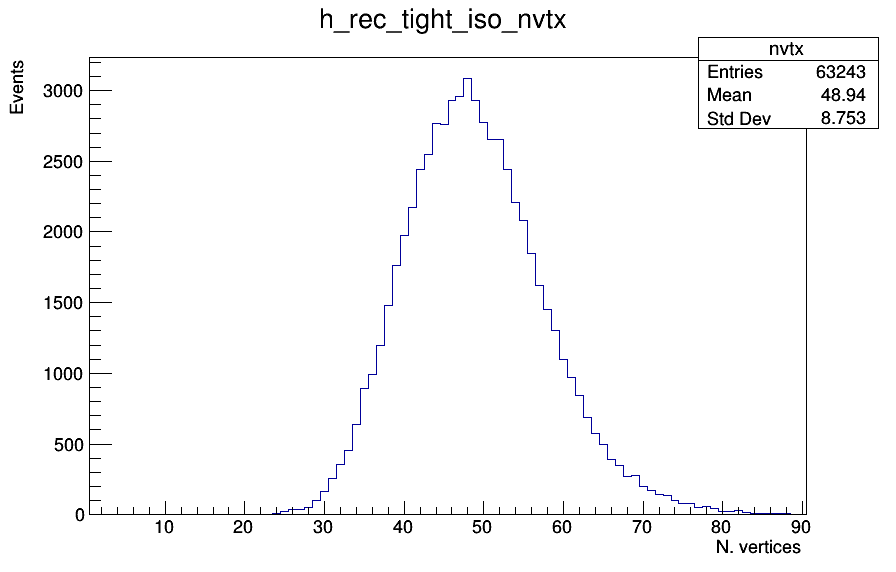

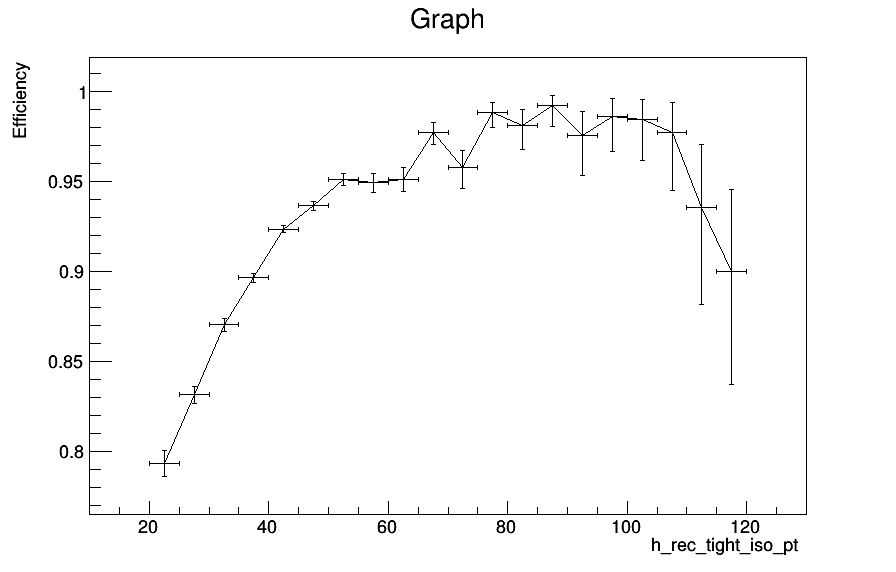

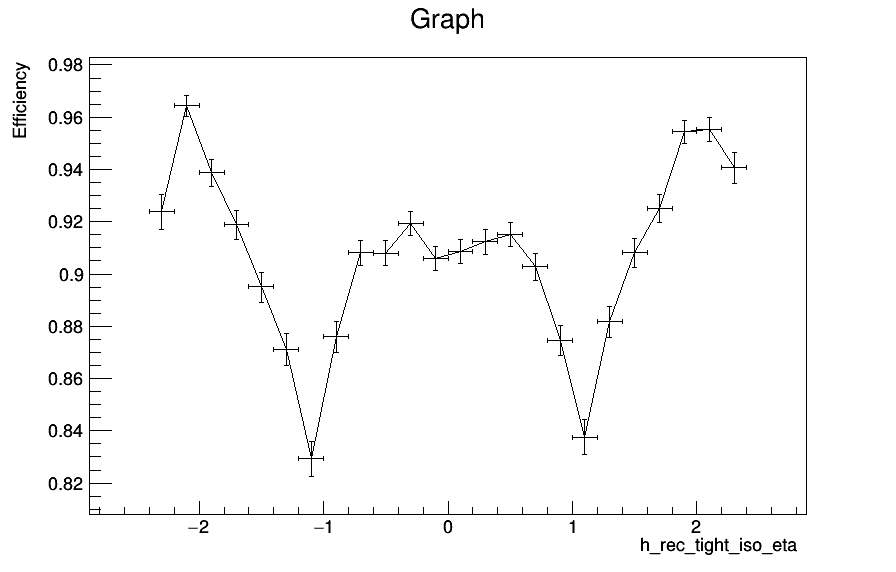

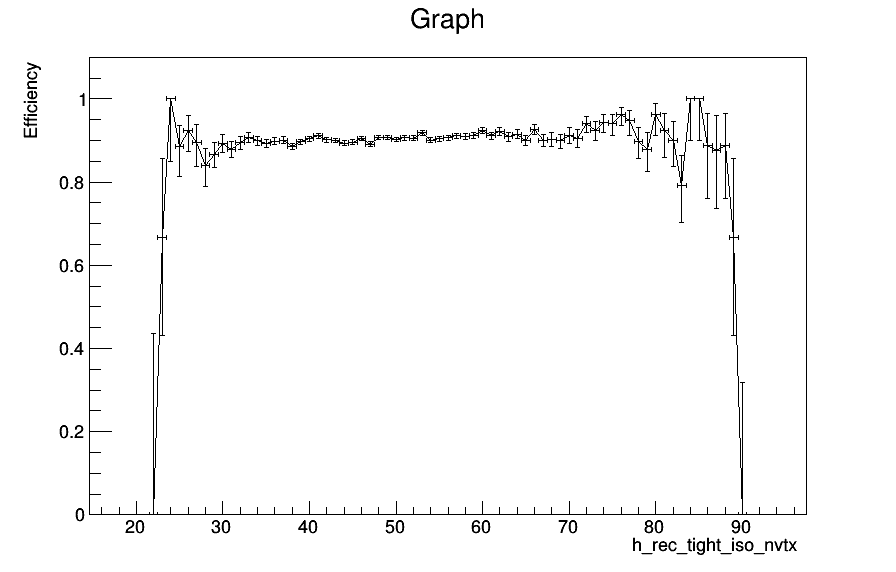

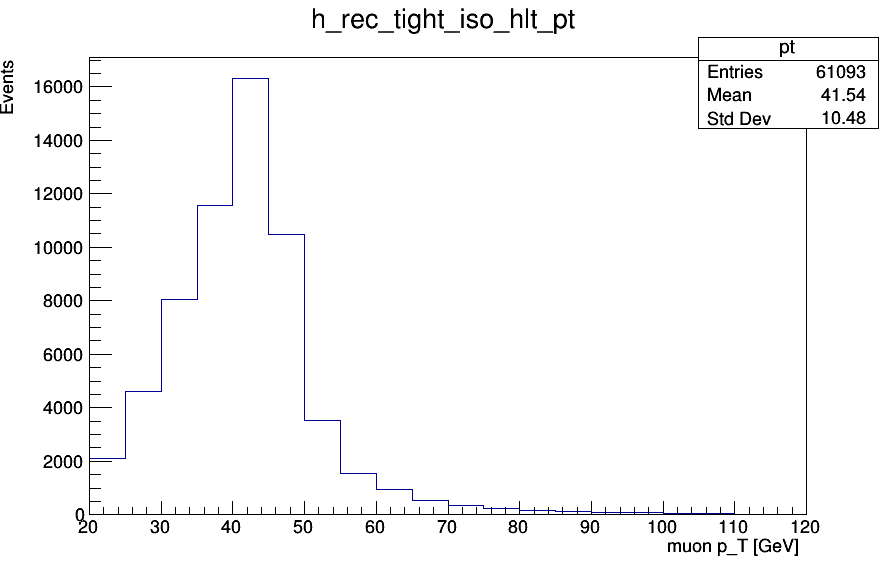

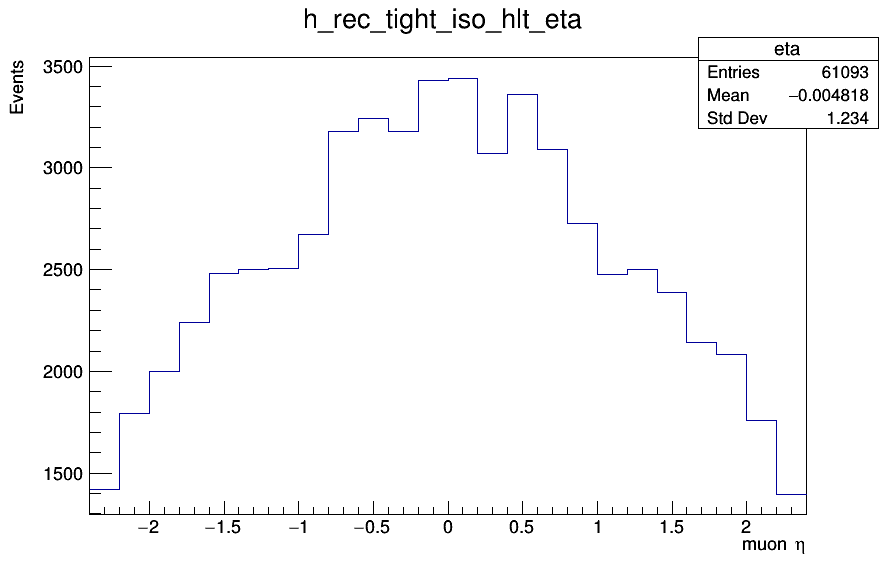

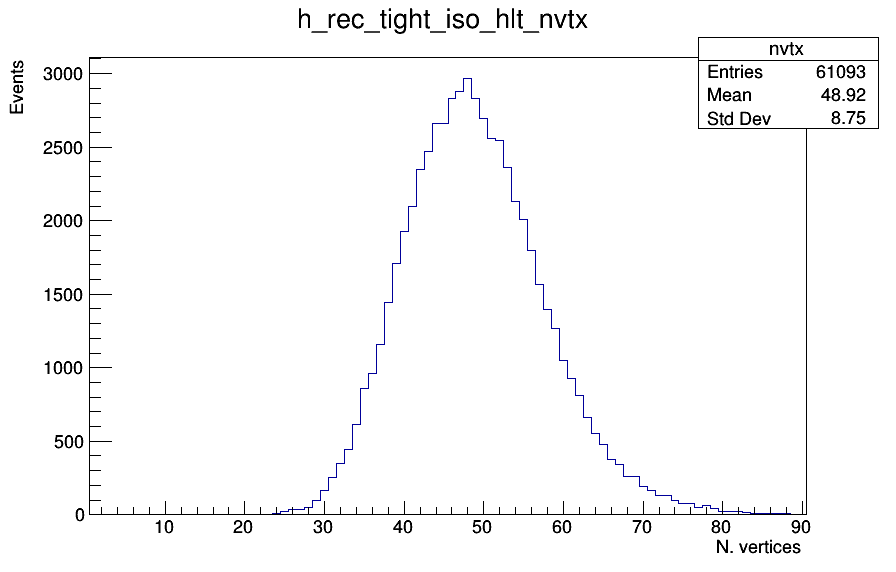

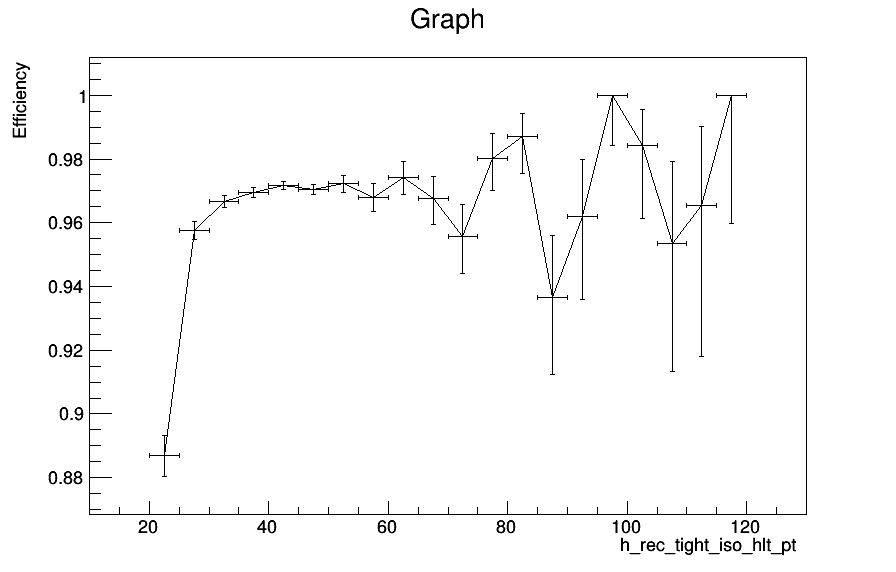

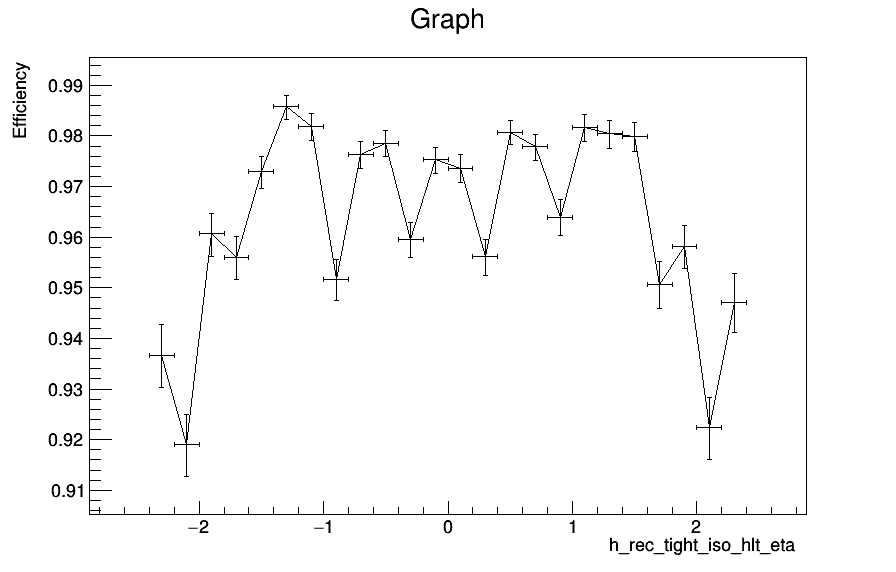

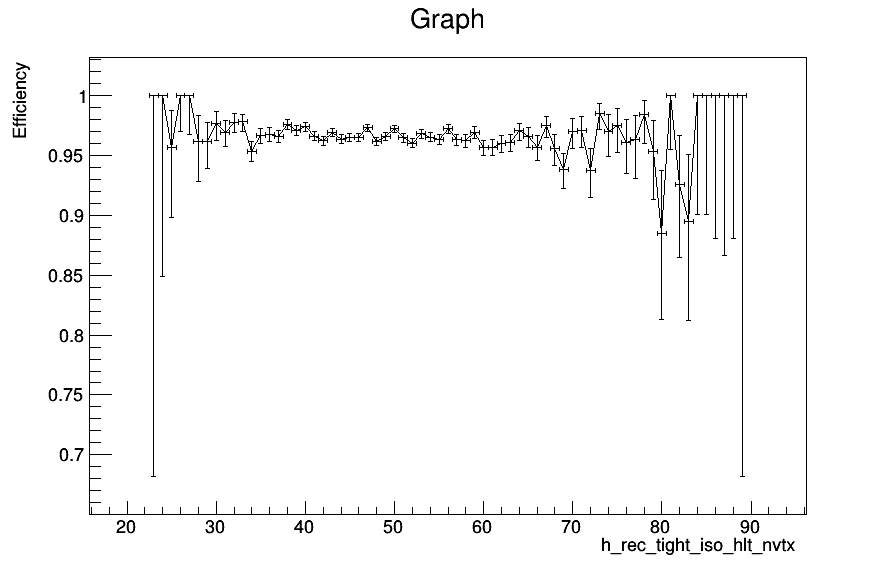

In [335]:
th1dic={}
efficiencydic={}
for name in ['rec', 'rec_loose', 'rec_medium', 'rec_tight', 'rec_tight_iso', 'rec_tight_iso_hlt']:
    if name== 'rec':
        th1dic[f'h_{name}_pt']=ROOT.TH1D("pt"  , f'h_{name}_pt;muon p_T [GeV];Events',  20,  20.0, 120.0)
        TH1_fill_and_plot(th1dic[f'h_{name}_pt'], muon.muon_pt[muon_mask[f'{name}']][event_mask_goodpv], f'h_{name}_pt')
        th1dic[f'h_{name}_eta']=ROOT.TH1D("eta" , f'h_{name}_eta;muon #eta;Events',  24,  -2.4,   2.4)
        TH1_fill_and_plot(th1dic[f'h_{name}_eta'], muon.muon_eta[muon_mask[f'{name}']][event_mask_goodpv], f'h_{name}_eta')
        th1dic[f'h_{name}_nvtx'] =ROOT.TH1D("nvtx", f'h_{name}_nvtx;N. vertices;Events',  90,   0.5,  90.5)
        TH1_fill_and_plot(th1dic[f'h_{name}_nvtx'], muon.pv_npvsgood[muon_mask[f'{name}']][event_mask_goodpv], f'h_{name}_nvtx')
        
        name2=name
        continue
        
    if name== 'rec_tight_iso_hlt':
        th1dic[f'h_{name}_pt']=ROOT.TH1D("pt"  , f'h_{name}_pt;muon p_T [GeV];Events',  20,  20.0, 120.0)
        TH1_fill_and_plot(th1dic[f'h_{name}_pt'], muon.muon_pt[muon_mask[f'{name}']][event_mask_goodpv_HLT_isomu24], f'h_{name}_pt')
        th1dic[f'h_{name}_eta']=ROOT.TH1D("eta" , f'h_{name}_eta;muon #eta;Events',  24,  -2.4,   2.4)
        TH1_fill_and_plot(th1dic[f'h_{name}_eta'], muon.muon_eta[muon_mask[f'{name}']][event_mask_goodpv_HLT_isomu24], f'h_{name}_eta')
        th1dic[f'h_{name}_nvtx'] =ROOT.TH1D("nvtx", f'h_{name}_nvtx;N. vertices;Events',  90,   0.5,  90.5)
        TH1_fill_and_plot(th1dic[f'h_{name}_nvtx'], muon.pv_npvsgood[muon_mask[f'{name}']][event_mask_goodpv_HLT_isomu24], f'h_{name}_nvtx')

        nbinpt   = th1dic['h_rec_pt'].GetNbinsX() 
        nbineta  = th1dic['h_rec_eta'].GetNbinsX() 
        nbinnvtx = th1dic['h_rec_nvtx'].GetNbinsX()
        
        efficiencydic[f'gae_{name}_pt']   = ROOT.TGraphAsymmErrors(nbinpt  ) 
        efficiencydic[f'gae_{name}_pt'].SetName(f'gae_{name}_pt')
        efficiencydic[f'gae_{name}_pt'].GetXaxis().SetTitle(f'h_{name}_pt')
        efficiencydic[f'gae_{name}_pt'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_pt'].Divide(th1dic[f'h_{name}_pt']  , th1dic[f'h_{name2}_pt']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_pt'], f'gae_{name}_pt')
        
        efficiencydic[f'gae_{name}_eta']   = ROOT.TGraphAsymmErrors(nbineta ) 
        efficiencydic[f'gae_{name}_eta'].SetName(f'gae_{name}_pt')
        efficiencydic[f'gae_{name}_eta'].GetXaxis().SetTitle(f'h_{name}_eta')
        efficiencydic[f'gae_{name}_eta'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_eta'].Divide(th1dic[f'h_{name}_eta']  , th1dic[f'h_{name2}_eta']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_eta'], f'gae_{name}_eta')
        
        efficiencydic[f'gae_{name}_nvtx']   = ROOT.TGraphAsymmErrors(nbinnvtx ) 
        efficiencydic[f'gae_{name}_nvtx'].SetName(f'gae_{name}_nvtx')
        efficiencydic[f'gae_{name}_nvtx'].GetXaxis().SetTitle(f'h_{name}_nvtx')
        efficiencydic[f'gae_{name}_nvtx'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_nvtx'].Divide(th1dic[f'h_{name}_nvtx']  , th1dic[f'h_{name2}_nvtx']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_nvtx'], f'gae_{name}_nvtx')
        
        name2=name
    else:
        th1dic[f'h_{name}_pt']=ROOT.TH1D("pt"  , f'h_{name}_pt;muon p_T [GeV];Events',  20,  20.0, 120.0)
        TH1_fill_and_plot(th1dic[f'h_{name}_pt'], muon.muon_pt[muon_mask[f'{name}']][event_mask_goodpv], f'h_{name}_pt')
        th1dic[f'h_{name}_eta']=ROOT.TH1D("eta" , f'h_{name}_eta;muon #eta;Events',  24,  -2.4,   2.4)
        TH1_fill_and_plot(th1dic[f'h_{name}_eta'], muon.muon_eta[muon_mask[f'{name}']][event_mask_goodpv], f'h_{name}_eta')
        th1dic[f'h_{name}_nvtx'] =ROOT.TH1D("nvtx", f'h_{name}_nvtx;N. vertices;Events',  90,   0.5,  90.5)
        TH1_fill_and_plot(th1dic[f'h_{name}_nvtx'], muon.pv_npvsgood[muon_mask[f'{name}']][event_mask_goodpv], f'h_{name}_nvtx')
        
        nbinpt   = th1dic['h_rec_pt'].GetNbinsX() 
        nbineta  = th1dic['h_rec_eta'].GetNbinsX() 
        nbinnvtx = th1dic['h_rec_nvtx'].GetNbinsX()
        
        efficiencydic[f'gae_{name}_pt']   = ROOT.TGraphAsymmErrors(nbinpt  ) 
        efficiencydic[f'gae_{name}_pt'].SetName(f'gae_{name}_pt')
        efficiencydic[f'gae_{name}_pt'].GetXaxis().SetTitle(f'h_{name}_pt')
        efficiencydic[f'gae_{name}_pt'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_pt'].Divide(th1dic[f'h_{name}_pt']  , th1dic[f'h_{name2}_pt']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_pt'], f'gae_{name}_pt')
        
        efficiencydic[f'gae_{name}_eta']   = ROOT.TGraphAsymmErrors(nbineta ) 
        efficiencydic[f'gae_{name}_eta'].SetName(f'gae_{name}_pt')
        efficiencydic[f'gae_{name}_eta'].GetXaxis().SetTitle(f'h_{name}_eta')
        efficiencydic[f'gae_{name}_eta'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_eta'].Divide(th1dic[f'h_{name}_eta']  , th1dic[f'h_{name2}_eta']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_eta'], f'gae_{name}_eta')
        
        efficiencydic[f'gae_{name}_nvtx']   = ROOT.TGraphAsymmErrors(nbinnvtx ) 
        efficiencydic[f'gae_{name}_nvtx'].SetName(f'gae_{name}_nvtx')
        efficiencydic[f'gae_{name}_nvtx'].GetXaxis().SetTitle(f'h_{name}_nvtx')
        efficiencydic[f'gae_{name}_nvtx'].GetYaxis().SetTitle('Efficiency')
        try:
            efficiencydic[f'gae_{name}_nvtx'].Divide(th1dic[f'h_{name}_nvtx']  , th1dic[f'h_{name2}_nvtx']  , "cl=0.683 b(1,1) mode")
        except:
            print("An exception occurred")
        eff_fill_and_plot(efficiencydic[f'gae_{name}_nvtx'], f'gae_{name}_nvtx')
        
        name2=name


In [ ]:
mass = np.sqrt(2*m1.pt*m2.pt*(np.cosh(m1.eta - m2.eta) - np.cos(m1.phi - m2.phi)))

In [213]:
for pt, eta, npv in zip(gen_muon[event_mask_goodpv].pt.flatten(), gen_muon[event_mask_goodpv].eta.flatten(), gen_muon[event_mask_goodpv].npv.flatten()):
    h_pt.Fill(pt)
    h_eta.Fill(eta)
    h_nvtx.Fill(npv)
    

Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_pt
Warning in <TCanvas::Constructor>: Deleting canvas with same name: h_eta


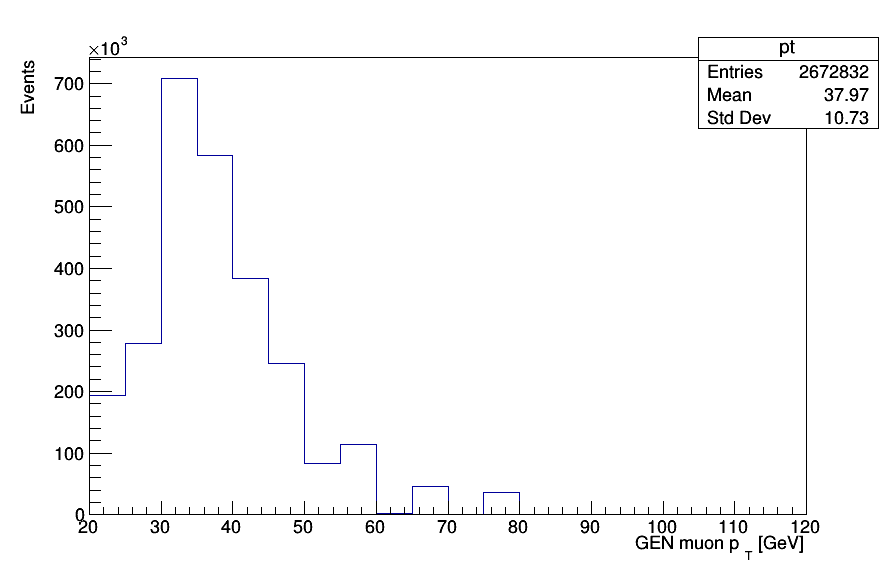

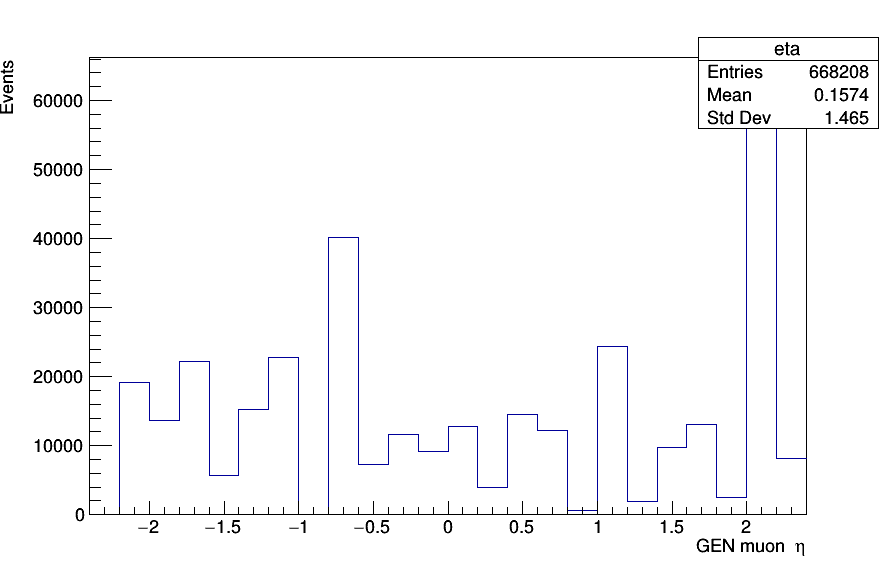

In [250]:
TH1_fill_and_plot(h_pt, gen_muon[event_mask_goodpv].pt, 'h_pt')
TH1_fill_and_plot(h_eta, gen_muon[event_mask_goodpv].eta, 'h_eta')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: gendimuonmass


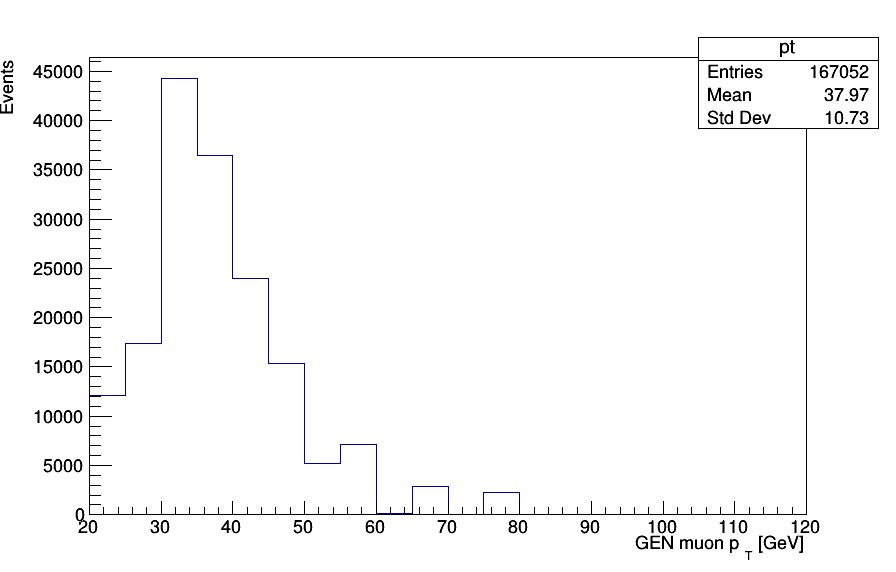

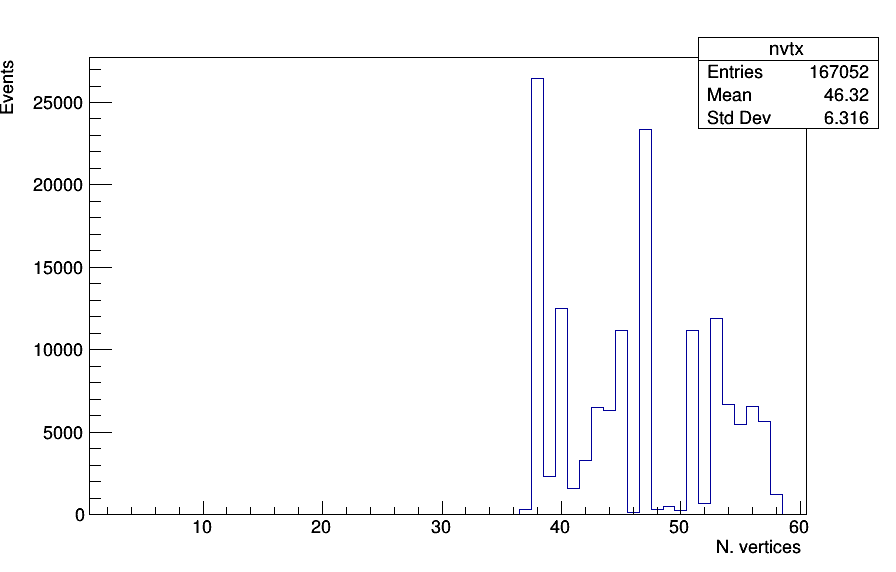

In [226]:
c1= ROOT.TCanvas("gendimuonmass","",900,600)
h_pt.Draw()
c1.Draw()

c= ROOT.TCanvas("genimuonmass","",900,600)
h_eta.Draw()
c.Draw()
h_nvtx.Draw()
c.Draw()

In [72]:
ak.crossing([[1, 2, 3, 4], [], [5, 6]], 2).tolist()

AttributeError: module 'awkward' has no attribute 'crossing'